`TTbarResCoffea` Notebook to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
This module must be run twice: 
   1. Make the mistag rate in the "anti-tag and probe" selection 
and the expectation in the signal region from MC,
   1. Applies that mistag rate and the mod-mass procedure to the single-tag selection. 

These are all done in bins of
b-tag categories (0, 1, $\ge 2$) and rapidity ($|y| \le 1.0$, $|y| > 1.0$).
The signal region is two top-tagged jets. 
The background estimate is the single-tag selection weighted by the mistag rate from the
"anti-tag and probe" region, with the mass of the weighted jet set to a random
value from QCD MC in the 1-ttag region. 


The preselection is:
- AK4-based $H_{T} > 1100$ GeV (to be on the trigger plateau). 
- $\ge 2$ AK8 jets with AK8 $p_{T} > 400$ GeV and $|y| < 2.5$, loose jet ID applied from matched AK4 jets

The 1-tag selection adds:
- $\ge 1$ AK8 jet with top tagging applied to randomly-assigned tag jet. 


The anti-tag selection is disjoint from the 1-tag selection:
- $\ge 1$ AK8 jet with top tagging VETO applied to randomly-assigned tag jet. 


The 2-tag selection is:
- $\ge 2$ AK8 jets with top tagging applied to both leading jets. 


The ttbar candidate mass assumes the two leading top-tagged jets are the top quarks. 


In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools

In [2]:
xrootdstr1 = 'root://cmseos.fnal.gov//'
xrootdstr2 = 'root://cmsxrootd.fnal.gov//'
xrootdstr3 = 'root://cmsxrootd-site.fnal.gov/'

In [3]:
qcdfilename = 'QCD.txt'
with open(qcdfilename) as f:
    qcdfiles = [xrootdstr2 + s.strip() for s in f.readlines()]

In [4]:
ttbarfilename = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8.txt'
with open(ttbarfilename) as f:
    ttbarfiles = [xrootdstr1 + s.strip() for s in f.readlines()]

In [5]:
jetdatafilename = 'JetHT_Data.txt'
with open(jetdatafilename) as f:
    jetdatafiles = [xrootdstr2 + s.strip() for s in f.readlines()]

In [6]:
from distributed import Client
client = Client('coffea-dask.fnal.gov:8786')

In [7]:
"""@TTbarResAnaHadronic Package to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
"""
class TTbarResProcessor(processor.ProcessorABC):
    def __init__(self, htCut=1100., minMSD=105., maxMSD=210., tau32Cut=0.7, ak8PtMin=400., bdisc=0.7,
                writePredDist=True,isData=True,year=2019):
        
        self.htCut = htCut
        self.minMSD = minMSD
        self.maxMSD = maxMSD
        self.tau32Cut = tau32Cut
        self.ak8PtMin = ak8PtMin
        self.bdisc = bdisc
        self.writePredDist = writePredDist
        self.writeHistFile = True
        self.isData = isData
        self.year=year
        
        self.ttagcats = ["at", "0t", "1t", "2t"] #anti-tag, 0, 1, >=2 ttags
        self.btagcats = ["0b", "1b", "2b"]   # 0, 1, >=2 btags
        self.ycats = ['cen', 'fwd']          # Central and forward
        # Combine categories like "0bcen", "0bfwd", etc:
        self.anacats = [ t+b+y for t,b,y in itertools.product( self.ttagcats, self.btagcats, self.ycats) ]
        print(self.anacats)
        
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        cats_axis = hist.Cat("anacat", "Analysis Category")
        
        ht_axis = hist.Bin("h_ak4ht", r"AK4 Jet H_{T} [GeV]", 50, 0, 5000)
        jetmass_axis = hist.Bin("jetmass", r"Jet $m$ [GeV]", 50, 0, 500)
        jetpt_axis = hist.Bin("jetpt", r"Jet $p_{T}$ [GeV]", 50, 0, 2000)
        jetn3b1_axis = hist.Bin("n3b1", r"Jet N3", 50, 0, 1)
        ttbarmass_axis = hist.Bin("ttbarmass", r"$m_{t\bar{t}}$ [GeV]", 50, 0, 5000)
        jeteta_axis = hist.Bin("jeteta", r"Jet $\eta$", 50, -4, 4)
        jetphi_axis = hist.Bin("jetphi", r"Jet $\phi$", 50, -3.14, 3.14)
        jetp_axis = hist.Bin("jetp", r"Jet $p$ [GeV]", 50, 0, 5000)
        
        subjetmass_axis = hist.Bin("subjetmass", r"SubJet $m$ [GeV]", 50, 0, 500)
        subjetpt_axis = hist.Bin("subjetpt", r"SubJet $p_{T}$ [GeV]", 50, 0, 2000)
        subjeteta_axis = hist.Bin("subjeteta", r"SubJet $\eta$", 50, -4, 4)
        subjetphi_axis = hist.Bin("subjetphi", r"SubJet $\phi$", 50, -3.14, 3.14)

        self._accumulator = processor.dict_accumulator({
            'ak4ht'  :   hist.Hist("Counts", dataset_axis, cats_axis, ht_axis),
            'ttbarmass': hist.Hist("Counts", dataset_axis, cats_axis, ttbarmass_axis),
            'jetmass':   hist.Hist("Counts", dataset_axis, cats_axis, jetmass_axis),
            'jetpt':     hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
            'jeteta':    hist.Hist("Counts", dataset_axis, cats_axis, jeteta_axis),
            'jetphi':    hist.Hist("Counts", dataset_axis, cats_axis, jetphi_axis),
            
            'subjetmass':   hist.Hist("Counts", dataset_axis, cats_axis, subjetmass_axis),
            'subjetpt':     hist.Hist("Counts", dataset_axis, cats_axis, subjetpt_axis),
            'subjeteta':    hist.Hist("Counts", dataset_axis, cats_axis, subjeteta_axis),
            'subjetphi':    hist.Hist("Counts", dataset_axis, cats_axis, subjetphi_axis),
            
            'numerator': hist.Hist("Counts", dataset_axis, cats_axis, jetp_axis),
            'denominator': hist.Hist("Counts", dataset_axis, cats_axis, jetp_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        
        output = self.accumulator.identity()
        
        
        #dataset = events.metadata['dataset']
        dataset = df['dataset']
        FatJets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'],
            eta=df['FatJet_eta'],
            phi=df['FatJet_phi'],
            mass=df['FatJet_mass'],
            msoftdrop=df['FatJet_msoftdrop'],
            jetId=df['FatJet_jetId'],
            tau1=df['FatJet_tau1'],
            tau2=df['FatJet_tau2'],
            tau3=df['FatJet_tau3'],
            tau4=df['FatJet_tau4'],
            n3b1=df['FatJet_n3b1'],
            btagDeepB=df['FatJet_btagDeepB'],
            deepTag_TvsQCD=df['FatJet_deepTag_TvsQCD'],
            deepTagMD_TvsQCD=df['FatJet_deepTagMD_TvsQCD']
            )
        SubJets = JaggedCandidateArray.candidatesfromcounts(
            df['nSubJet'],
            pt=df['SubJet_pt'],
            eta=df['SubJet_eta'],
            phi=df['SubJet_phi'],
            mass=df['SubJet_mass'],
            
            tau1=df['SubJet_tau1'],
            tau2=df['SubJet_tau2'],
            tau3=df['SubJet_tau3'],
            tau4=df['SubJet_tau4'],
            n2b1=df['SubJet_n2b1'],
            n3b1=df['SubJet_n3b1'],
            btagDeepB=df['SubJet_btagDeepB']
            )
        
        try:
            evtweights = df["Generator_weight"].reshape(-1, 1).flatten()
        except KeyError: # will happen when data file is used instead of monte carlo
            evtweights = np.ones(FatJets.size) # set all "data weights" to one
        
        output['cutflow']['all events'] += FatJets.size

        oneFatJet = (FatJets.counts >= 1)
        FatJets = FatJets[oneFatJet]
        evtweights = evtweights[oneFatJet]
        output['cutflow']['one FatJets'] += oneFatJet.sum()
        
        twoFatJets = (FatJets.counts >= 2)
        FatJets = FatJets[twoFatJets]
        evtweights = evtweights[twoFatJets]
        output['cutflow']['two FatJets'] += twoFatJets.sum()

        jet_id = (FatJets.jetId > 0)
        
        FatJets = FatJets[jet_id]
        output['cutflow']['jet id'] += jet_id.any().sum()
        
        jetkincut_index = (FatJets.pt > self.ak8PtMin) & (np.abs(FatJets.eta) < 2.5)
        FatJets = FatJets[ jetkincut_index ]
        output['cutflow']['jet kin'] += jetkincut_index.any().sum()

        twoFatJetsKin = (FatJets.counts >= 2)
        FatJets = FatJets[twoFatJetsKin]
        evtweights = evtweights[twoFatJetsKin]
        output['cutflow']['two FatJets and jet kin'] += twoFatJetsKin.sum()    
        
        index = JaggedArray.fromcounts(np.ones(len(FatJets), dtype='i'), np.random.randint(2, size=len(FatJets)))
        jet0 = FatJets[index]
        jet1 = FatJets[1 - index]
        
        ttbarcands = jet0.cross(jet1) #FatJets[:,0:2].distincts()
        
        oneTTbar = (ttbarcands.counts >= 1)
        output['cutflow']['>= one oneTTbar'] += oneTTbar.sum()
        ttbarcands = ttbarcands[oneTTbar]
        evtweights = evtweights[oneTTbar]
        FatJets = FatJets[oneTTbar]

        
        dPhiCut = (ttbarcands.i0.p4.delta_phi(ttbarcands.i1.p4) > 2.1).flatten()
        output['cutflow']['dPhi > 2.1'] += dPhiCut.sum()
        ttbarcands = ttbarcands[dPhiCut]
        evtweights = evtweights[dPhiCut]
        FatJets = FatJets[dPhiCut]        
        # Now get the analysis categories. 
        # They are (central, forward)   cross   (0b,1b,>=2b)
        cen = np.abs(ttbarcands.i0.p4.y - ttbarcands.i1.p4.y) < 1.0
        fwd = (~cen)
        tau32_i0 = np.where(ttbarcands.i0.tau2>0,ttbarcands.i0.tau3/ttbarcands.i0.tau2, 0 )
        tau32_i1 = np.where(ttbarcands.i1.tau2>0,ttbarcands.i1.tau3/ttbarcands.i1.tau2, 0 )
        taucut_i0 = tau32_i0 < self.tau32Cut
        taucut_i1 = tau32_i1 < self.tau32Cut
        mcut_i0 = (self.minMSD < ttbarcands.i0.msoftdrop) & (ttbarcands.i0.msoftdrop < self.maxMSD) 
        mcut_i1 = (self.minMSD < ttbarcands.i1.msoftdrop) & (ttbarcands.i1.msoftdrop < self.maxMSD) 

        ttag_i0 = (taucut_i0) & (mcut_i0)
        ttag_i1 = (taucut_i1) & (mcut_i1)
        antitag = (~taucut_i0) & (mcut_i0) #Probe will always be ttbarcands.i1
        ttag0 = (~ttag_i0) & (~ttag_i1)
        ttag1 = ttag_i0 ^ ttag_i1
        ttag2 = ttag_i0 & ttag_i1

        btag_i0 = (ttbarcands.i0.btagDeepB > self.bdisc)
        btag_i1 = (ttbarcands.i1.btagDeepB > self.bdisc)
        
        btag0 = (~btag_i0) & (~btag_i1)
        btag1 = btag_i0 ^ btag_i1
        btag2 = btag_i0 & btag_i1
        
        antitag_probe = np.logical_and(antitag, ttag_i1) #Found an antitag and ttaged probe pair
      
        regs = [cen,fwd]
        btags = [btag0,btag1,btag2]
        ttags = [antitag,ttag0,ttag1,ttag2]
        cats = [ (t&b&y).flatten() for t,b,y in itertools.product( ttags, btags, regs) ]
        
        labels_and_categories = dict(zip( self.anacats, cats ))
        ttbarmass = ttbarcands.p4.sum().mass.flatten()
        jetpt = ttbarcands.pt.flatten()
        jeteta = ttbarcands.eta.flatten()
        jetphi = ttbarcands.phi.flatten()
        weights = evtweights.flatten()
        #print('weights = ', weights)
        #weights[weights < 0] = 0 # set negative weights to zero ONLY FOR TESTING SMALL SAMPLES
        
        pT = ttbarcands.i1.pt.flatten()
        eta = ttbarcands.i1.eta.flatten()
        pz = np.sinh(eta)*pT
        p = np.absolute(np.sqrt(pT**2 + pz**2))
        numerator = np.where(antitag_probe, p, -9999) 
        denominator = np.where(antitag, p, -9999)
        #print("n = ", numerator)
        #print("d = ", denominator)

        for ilabel,icat in labels_and_categories.items():
            output['cutflow'][ilabel] += np.sum(icat)
            output['ttbarmass'].fill(dataset=dataset, anacat=ilabel, 
                                ttbarmass=ttbarmass[icat],
                                weight=weights[icat])
            output['jetpt'].fill(dataset=dataset, anacat=ilabel, 
                                jetpt=jetpt[icat],
                                weight=weights[icat])
            output['jeteta'].fill(dataset=dataset, anacat=ilabel, 
                                jeteta=jeteta[icat],
                                weight=weights[icat])
            output['jetphi'].fill(dataset=dataset, anacat=ilabel, 
                                jetphi=jetphi[icat],
                                weight=weights[icat])
            output['numerator'].fill(dataset=dataset, anacat=ilabel, 
                                jetp=numerator[icat],
                                weight=weights[icat])
            output['denominator'].fill(dataset=dataset, anacat=ilabel, 
                                jetp=denominator[icat],
                                weight=weights[icat])
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [10]:
tstart = time.time()

fileset = {
    'TTbar':ttbarfiles,
    'QCD':qcdfiles,
    'JetHT':jetdatafiles
}

output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=TTbarResProcessor(),
                                  #executor=processor.dask_executor,
                                  executor=processor.iterative_executor,
                                  executor_args={
                                      'client': client, 
                                      'nano':False, 
                                      'flatten':True, 
                                      #'skipbadfiles':True,
                                      'workers': 4},
                                  chunksize=50000 , maxchunks=300
                                 )

elapsed = time.time() - tstart
print(output)

['at0bcen', 'at0bfwd', 'at1bcen', 'at1bfwd', 'at2bcen', 'at2bfwd', '0t0bcen', '0t0bfwd', '0t1bcen', '0t1bfwd', '0t2bcen', '0t2bfwd', '1t0bcen', '1t0bfwd', '1t1bcen', '1t1bfwd', '1t2bcen', '1t2bfwd', '2t0bcen', '2t0bfwd', '2t1bcen', '2t1bfwd', '2t2bcen', '2t2bfwd']



{'ak4ht': <Hist (dataset,anacat,h_ak4ht) instance at 0x7fac0c1c7e90>, 'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7fabda7cd390>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7fabda7cd5d0>, 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7fabda7cdb10>, 'jeteta': <Hist (dataset,anacat,jeteta) instance at 0x7fabda7cdd50>, 'jetphi': <Hist (dataset,anacat,jetphi) instance at 0x7fac386f7550>, 'subjetmass': <Hist (dataset,anacat,subjetmass) instance at 0x7fac04396950>, 'subjetpt': <Hist (dataset,anacat,subjetpt) instance at 0x7fac04625850>, 'subjeteta': <Hist (dataset,anacat,subjeteta) instance at 0x7fabf1523850>, 'subjetphi': <Hist (dataset,anacat,subjetphi) instance at 0x7fac0da765d0>, 'numerator': <Hist (dataset,anacat,jetp) instance at 0x7fabf094a590>, 'denominator': <Hist (dataset,anacat,jetp) instance at 0x7fabf19d7990>, 'cutflow': defaultdict_accumulator(<class 'int'>, {'all events': 44641456, 'one FatJets': 23757002, 'two FatJets': 17280132, 'jet id': 1

In [ ]:
#print(output['jetpt']['TTbar'])

In [11]:
stack_fill_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,.5)}
stack_error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
data_err_opts = {'linestyle': 'none', 'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1}

In [12]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [13]:
def DoesDirectoryExist(mypath): #extra precaution
    '''Checks to see if Directory exists before making a new one'''
    import os.path
    from os import path
    
    if path.exists(mypath):
        pass
    else:
        mkdir_p(mypath)

In [14]:
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
warnings.filterwarnings("ignore")

# ---- Reiterate categories ---- #
ttagcats = ["at", "0t", "1t", "2t"]
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

list_of_cats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]
list_of_hists = ('ttbarmass', 'jetpt', 'jeteta', 'jetphi',
                 'numerator', 'denominator')

maindirectory = '/uscms_data/d1/acwillia/singularity/TTbarAllHadUprootFork/TTbarAllHadUproot' # change accordingly

mistag_TTbar_at0bcen.png saved
mistag_TTbar_at0bfwd.png saved
mistag_TTbar_at1bcen.png saved
mistag_TTbar_at1bfwd.png saved
mistag_TTbar_at2bcen.png saved
mistag_TTbar_at2bfwd.png saved
mistag_TTbar_0t0bcen.png saved
mistag_TTbar_0t0bfwd.png saved
mistag_TTbar_0t1bcen.png saved
mistag_TTbar_0t1bfwd.png saved
mistag_TTbar_0t2bcen.png saved
mistag_TTbar_0t2bfwd.png saved
mistag_TTbar_1t0bcen.png saved
mistag_TTbar_1t0bfwd.png saved
mistag_TTbar_1t1bcen.png saved
mistag_TTbar_1t1bfwd.png saved
mistag_TTbar_1t2bcen.png saved
mistag_TTbar_1t2bfwd.png saved
mistag_TTbar_2t0bcen.png saved
mistag_TTbar_2t0bfwd.png saved
mistag_TTbar_2t1bcen.png saved
mistag_TTbar_2t1bfwd.png saved
mistag_TTbar_2t2bcen.png saved
mistag_TTbar_2t2bfwd.png saved
mistag_QCD_at0bcen.png saved
mistag_QCD_at0bfwd.png saved
mistag_QCD_at1bcen.png saved
mistag_QCD_at1bfwd.png saved
mistag_QCD_at2bcen.png saved
mistag_QCD_at2bfwd.png saved
mistag_QCD_0t0bcen.png saved
mistag_QCD_0t0bfwd.png saved
mistag_QCD_0t1bcen.png s

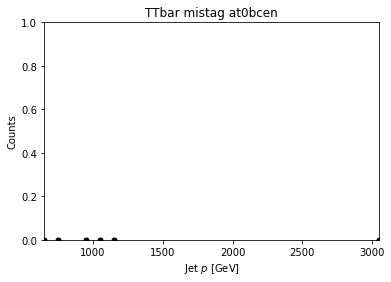

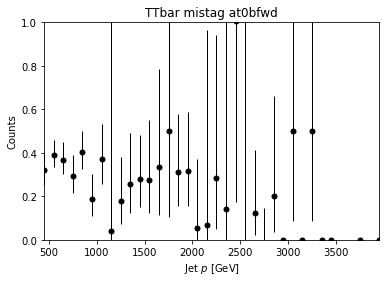

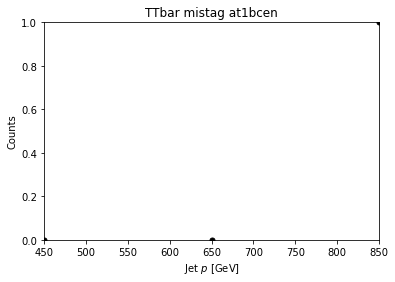

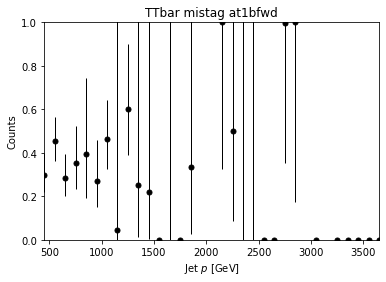

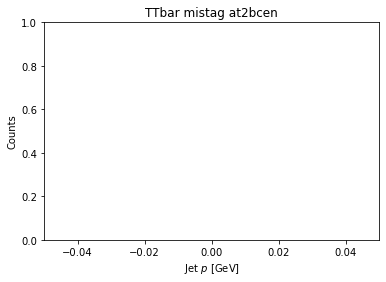

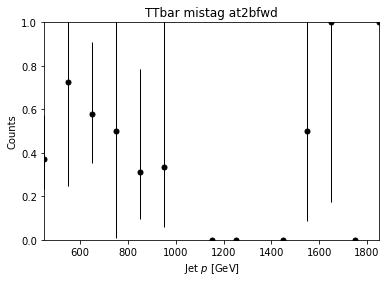

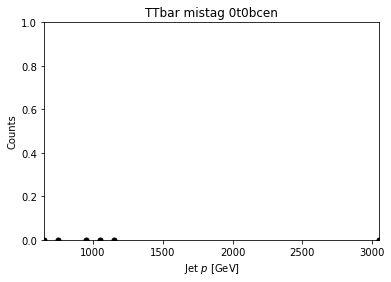

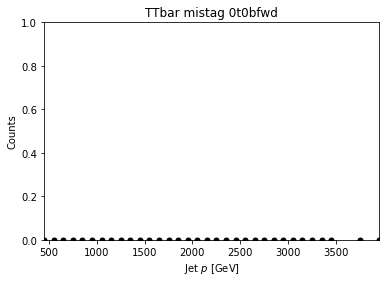

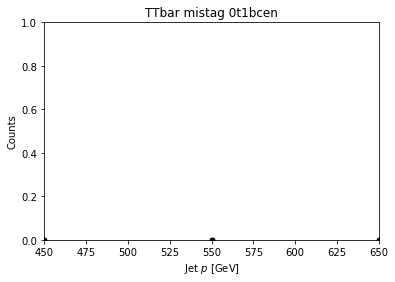

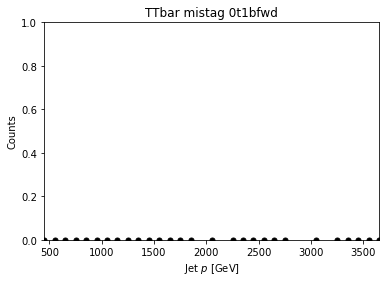

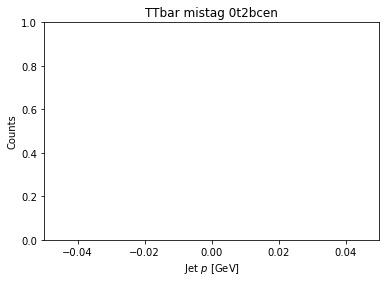

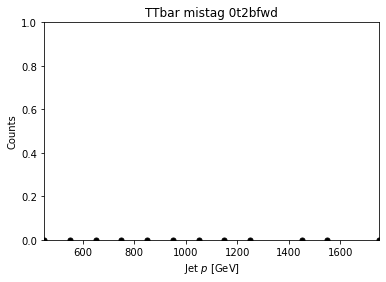

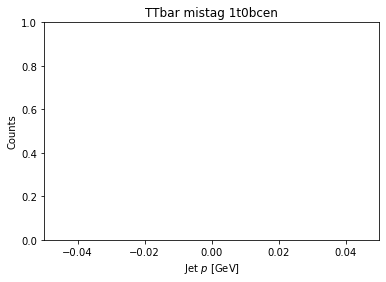

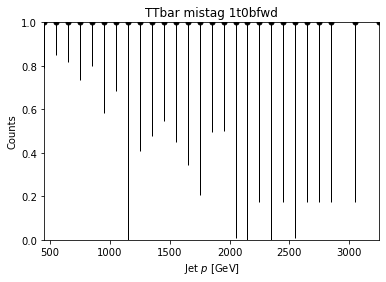

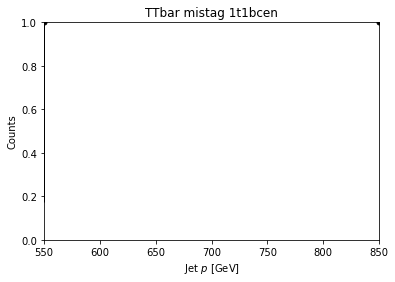

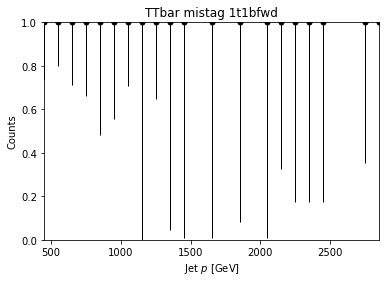

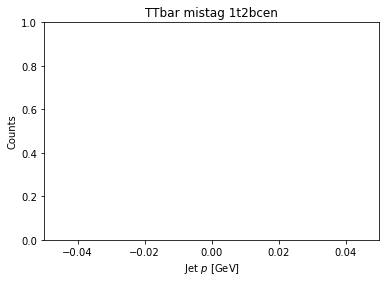

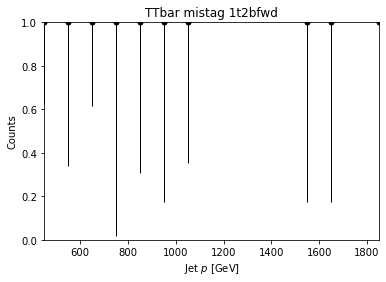

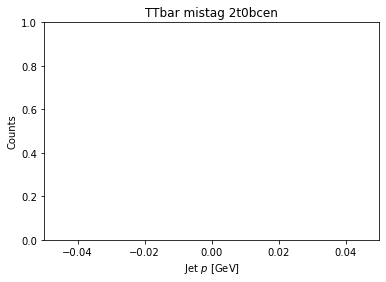

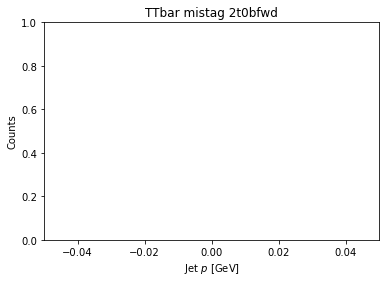

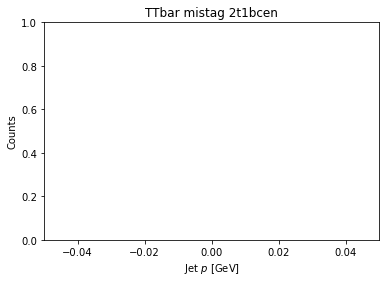

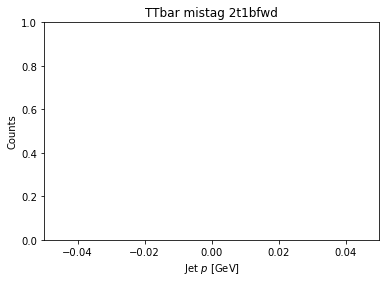

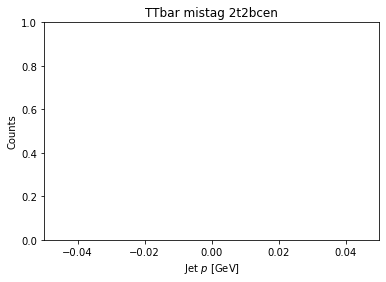

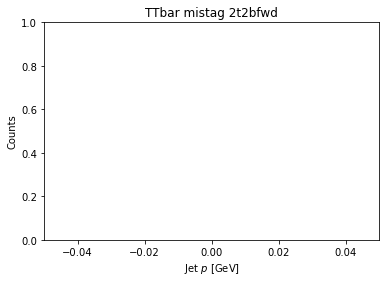

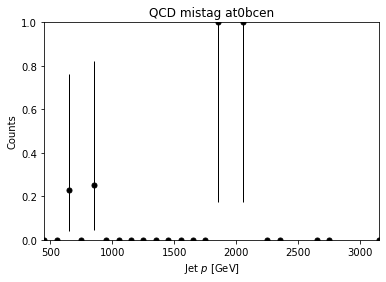

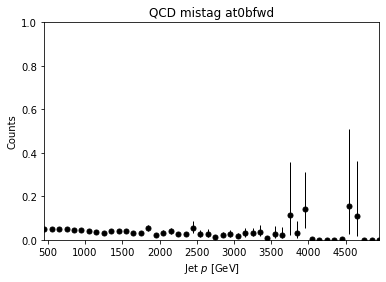

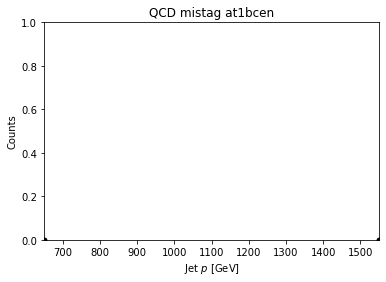

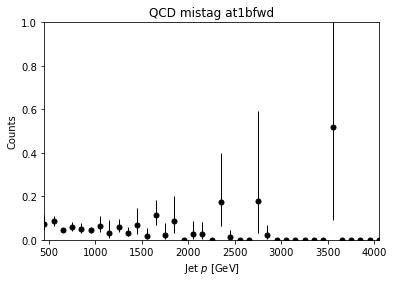

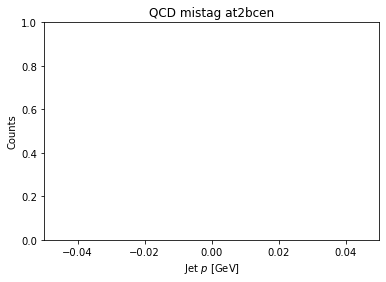

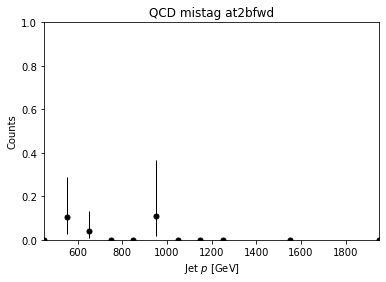

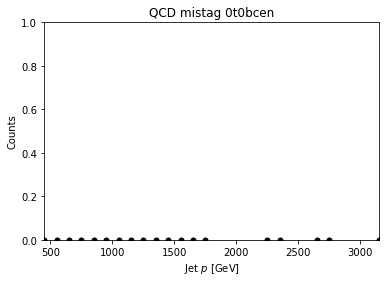

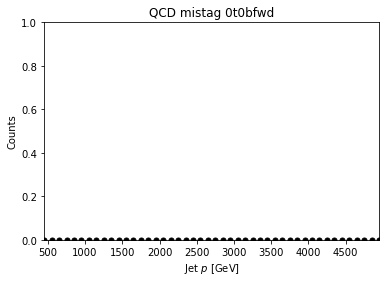

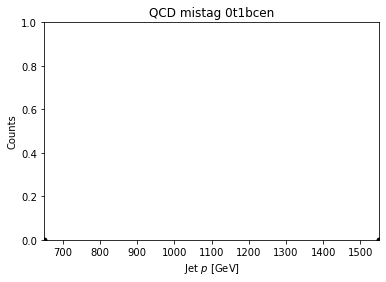

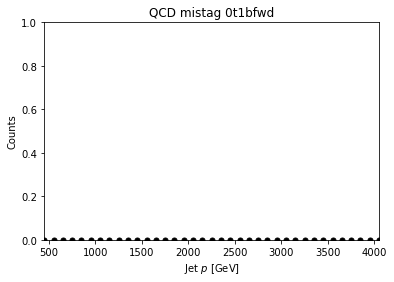

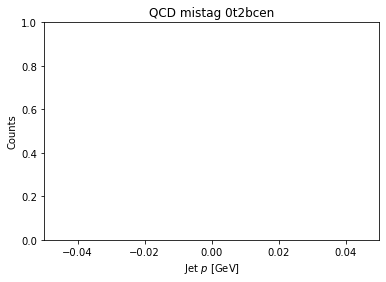

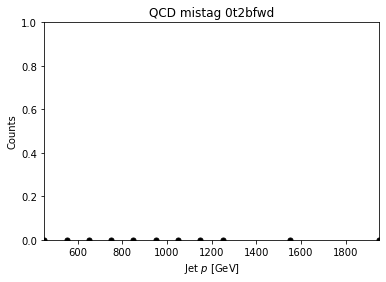

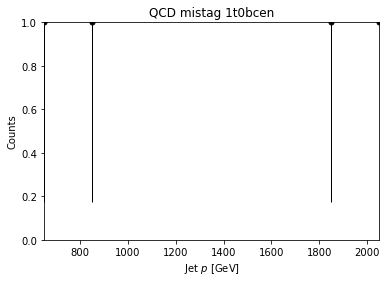

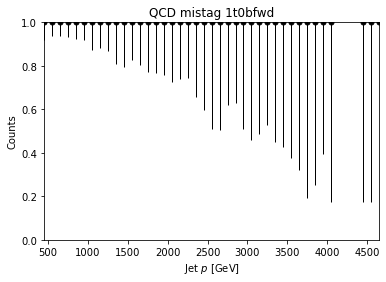

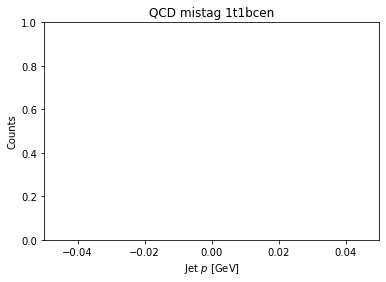

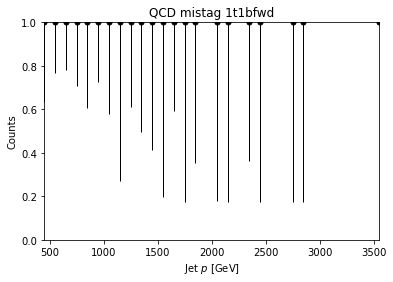

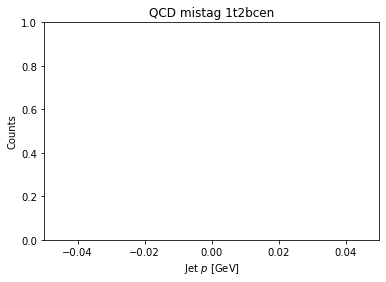

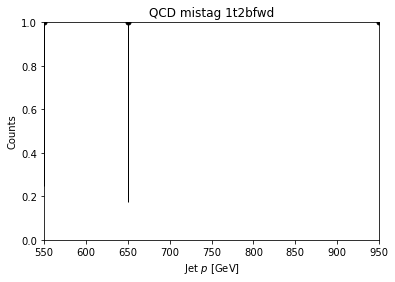

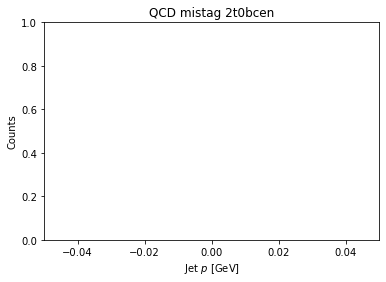

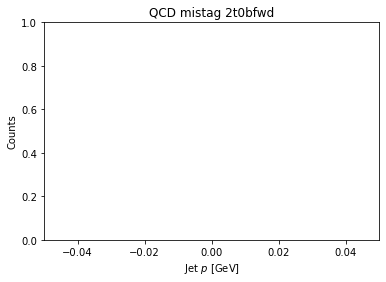

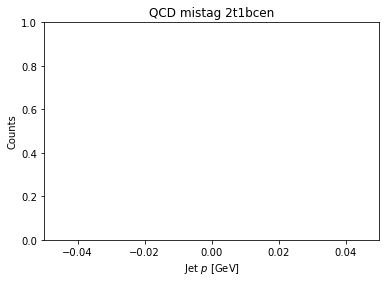

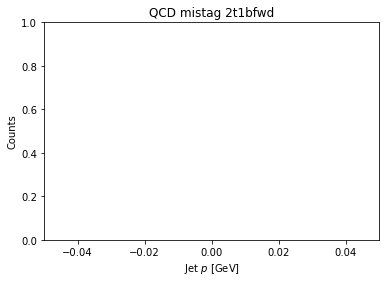

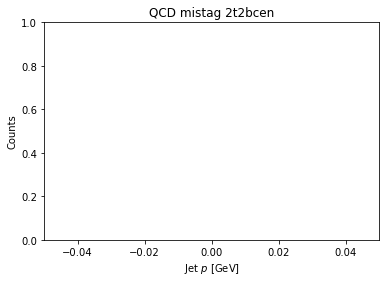

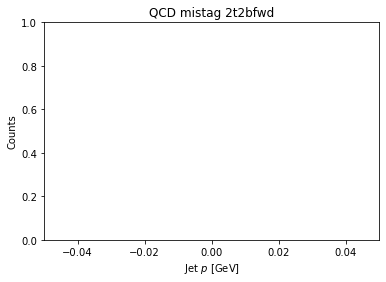

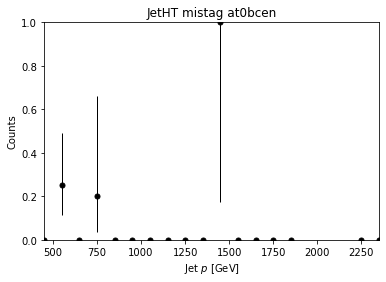

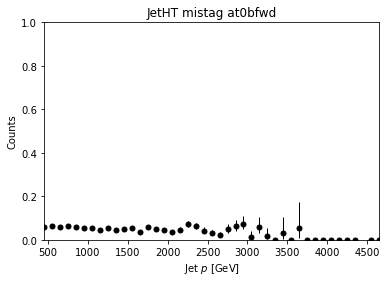

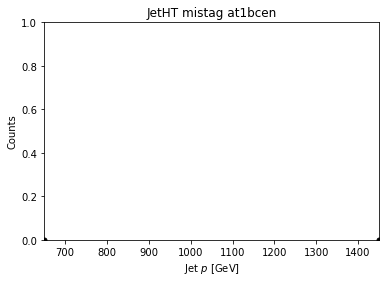

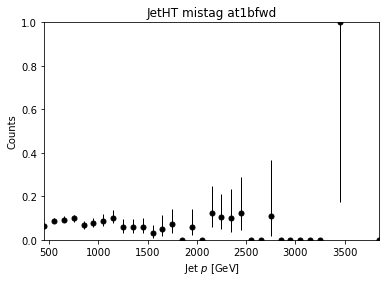

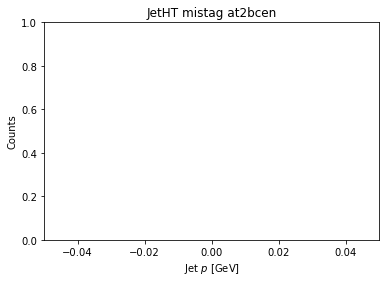

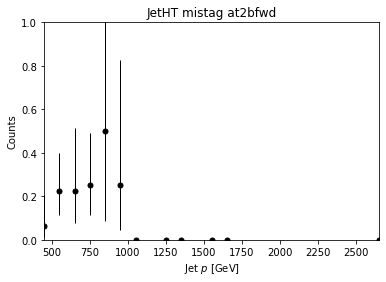

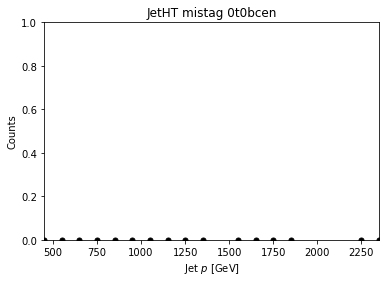

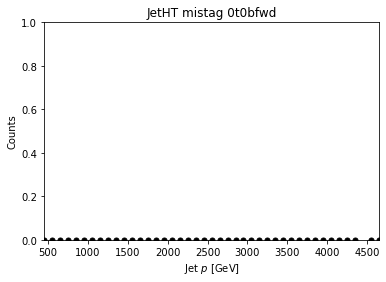

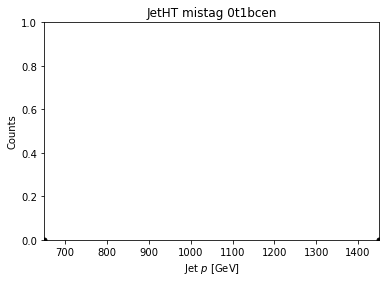

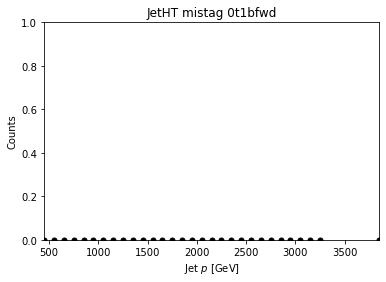

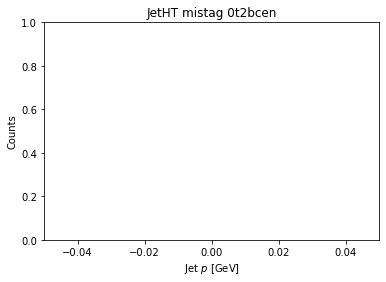

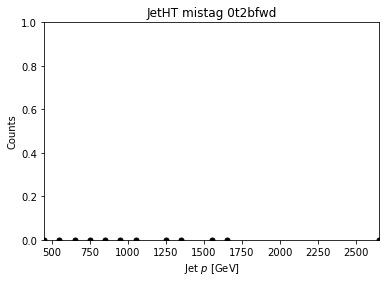

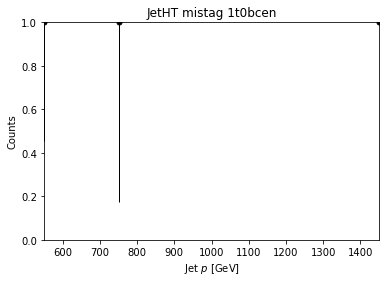

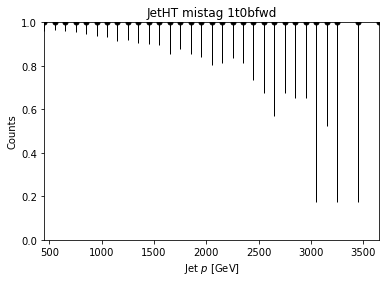

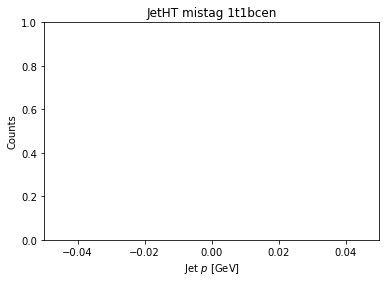

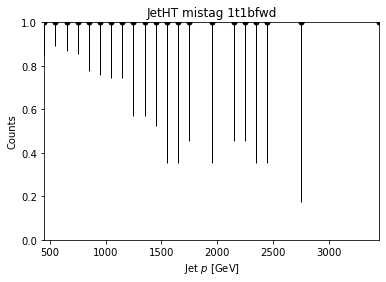

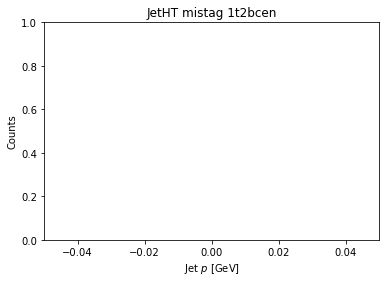

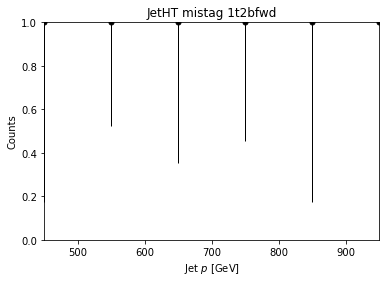

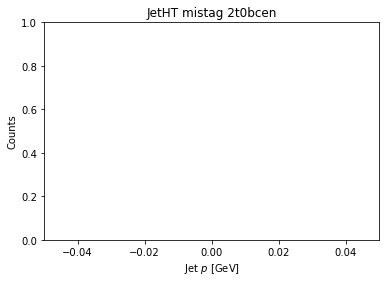

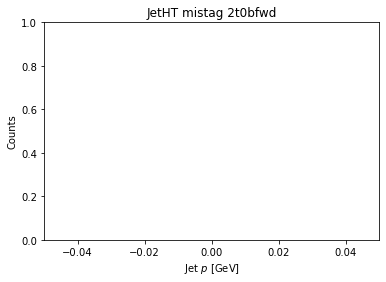

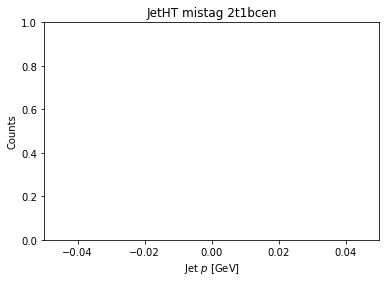

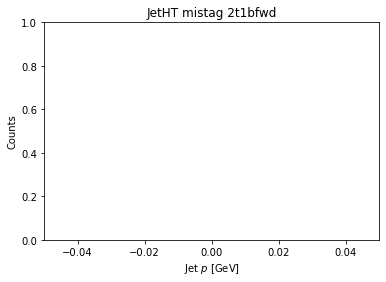

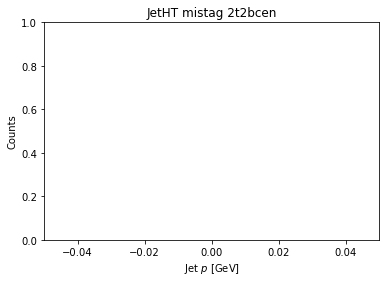

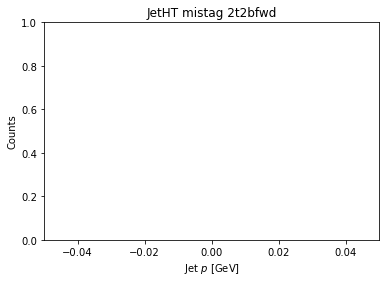

In [28]:
""" ---------------- CREATES MISTAG PLOTS ---------------- """
SaveDirectory = maindirectory + '/MistagPlots/'
DoesDirectoryExist(SaveDirectory) # no need to create the directory several times
for iset in fileset:
    for icat in list_of_cats:
        title = iset + ' mistag ' + icat
        filename = 'mistag_' + iset + '_' + icat + '.' + 'png'
        Numerator = output['numerator'].integrate('anacat', icat).integrate('dataset', iset)
        Denominator = output['denominator'].integrate('anacat', icat).integrate('dataset', iset)
        mistag = hist.plotratio(num = Numerator, denom = Denominator,
                                error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                                unc = 'num')
        plt.title(title)
        plt.ylim(bottom = 0, top = 1.0)
        plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        print(filename + ' saved')

ttbarmass_at0bcen.png saved
ttbarmass_at0bfwd.png saved
ttbarmass_at1bcen.png saved
ttbarmass_at1bfwd.png saved
ttbarmass_at2bcen.png saved
ttbarmass_at2bfwd.png saved
ttbarmass_0t0bcen.png saved
ttbarmass_0t0bfwd.png saved
ttbarmass_0t1bcen.png saved
ttbarmass_0t1bfwd.png saved
ttbarmass_0t2bcen.png saved
ttbarmass_0t2bfwd.png saved
ttbarmass_1t0bcen.png saved
ttbarmass_1t0bfwd.png saved
ttbarmass_1t1bcen.png saved
ttbarmass_1t1bfwd.png saved
ttbarmass_1t2bcen.png saved
ttbarmass_1t2bfwd.png saved
ttbarmass_2t0bcen.png saved
ttbarmass_2t0bfwd.png saved
ttbarmass_2t1bcen.png saved
ttbarmass_2t1bfwd.png saved
ttbarmass_2t2bcen.png saved
ttbarmass_2t2bfwd.png saved
jetpt_at0bcen.png saved
jetpt_at0bfwd.png saved
jetpt_at1bcen.png saved
jetpt_at1bfwd.png saved
jetpt_at2bcen.png saved
jetpt_at2bfwd.png saved
jetpt_0t0bcen.png saved
jetpt_0t0bfwd.png saved
jetpt_0t1bcen.png saved
jetpt_0t1bfwd.png saved
jetpt_0t2bcen.png saved
jetpt_0t2bfwd.png saved
jetpt_1t0bcen.png saved
jetpt_1t0bfwd.pn

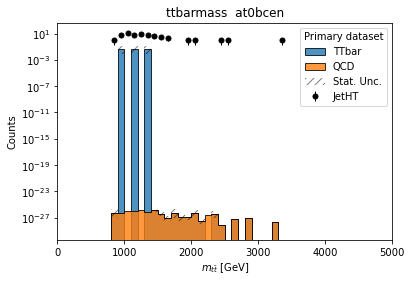

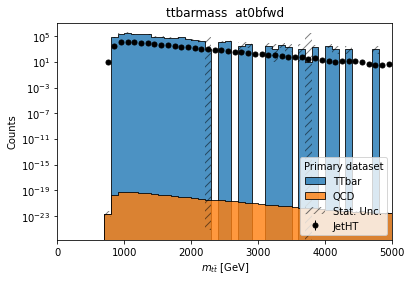

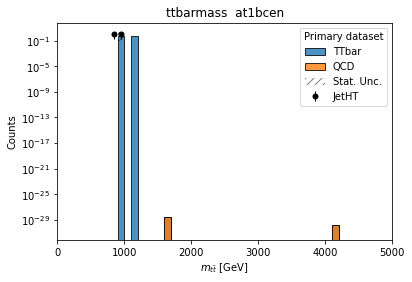

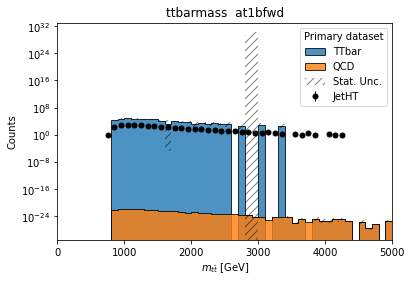

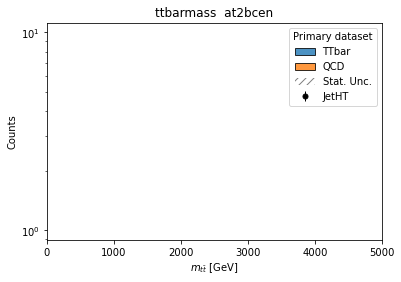

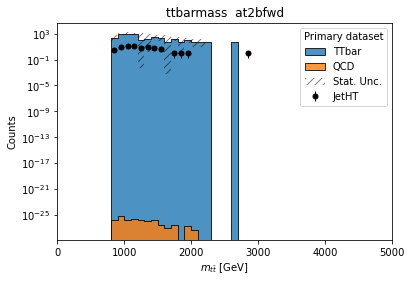

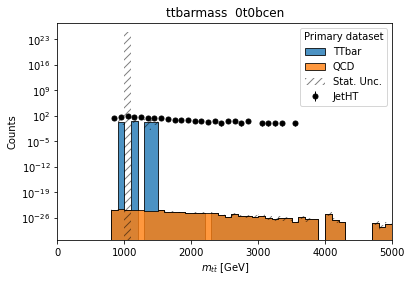

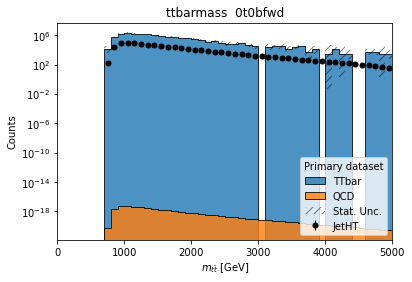

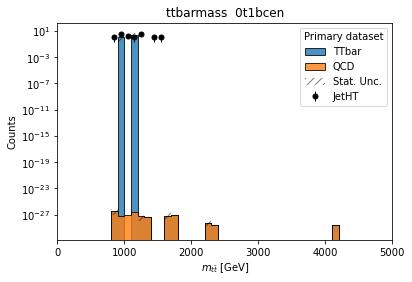

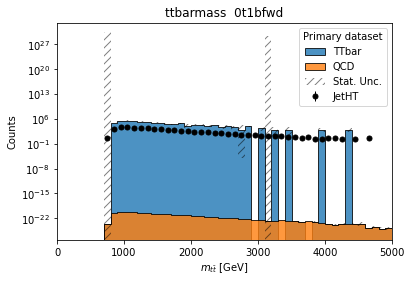

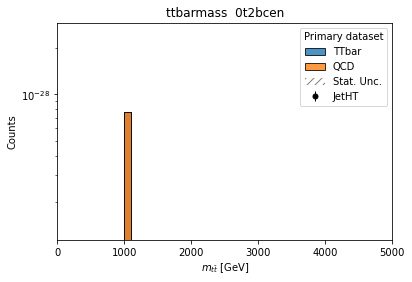

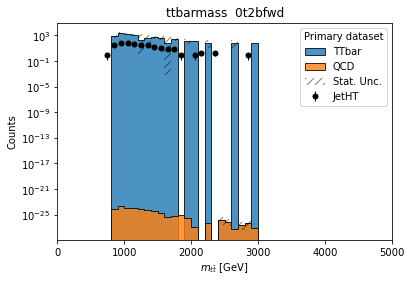

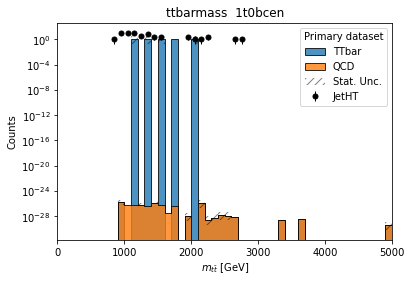

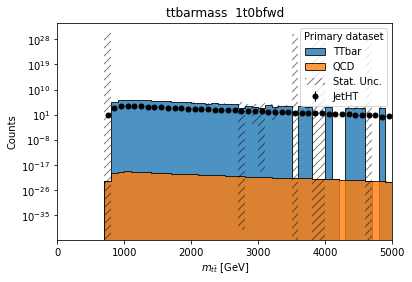

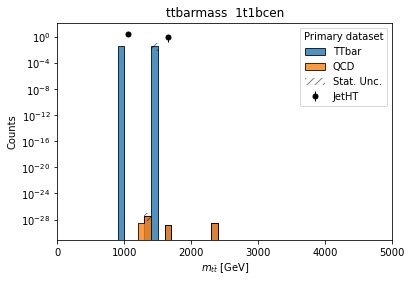

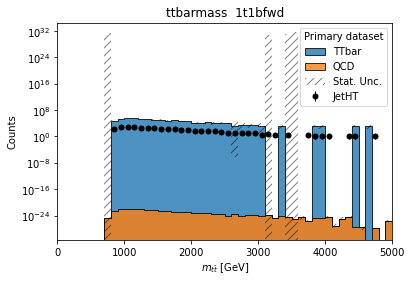

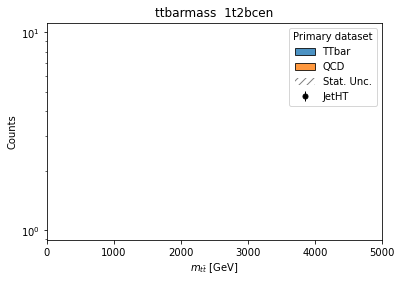

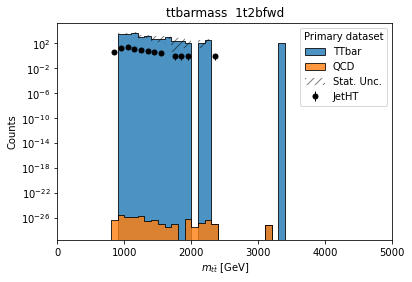

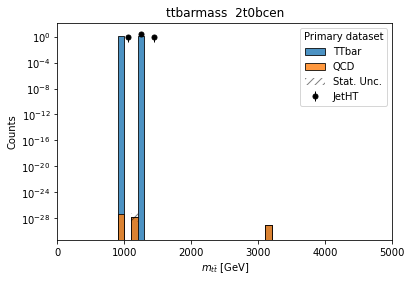

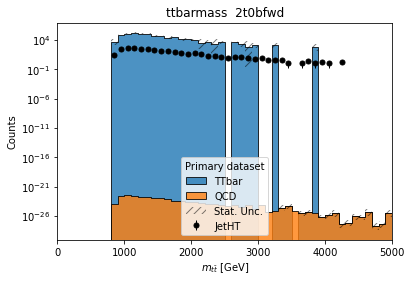

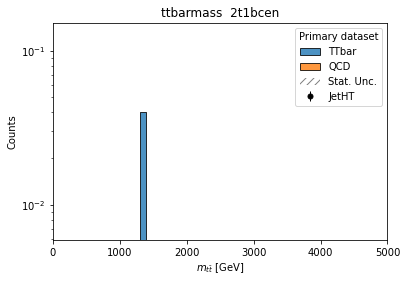

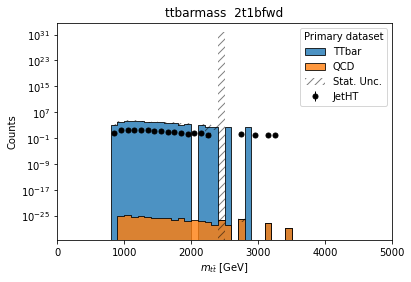

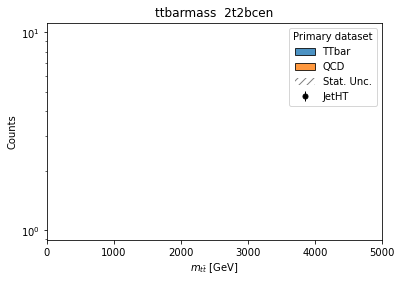

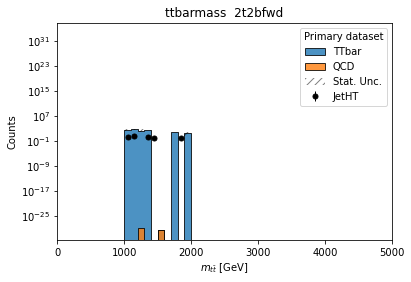

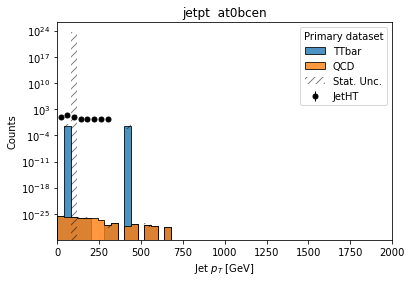

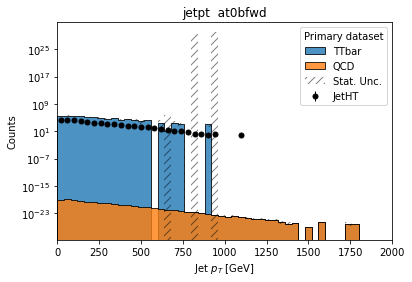

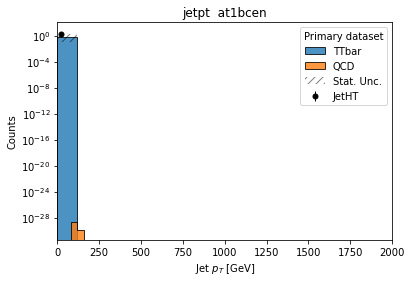

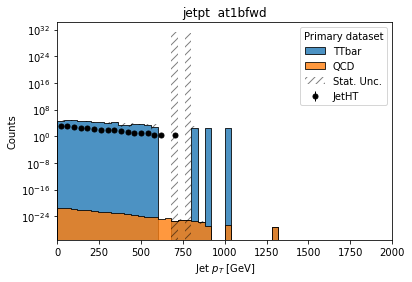

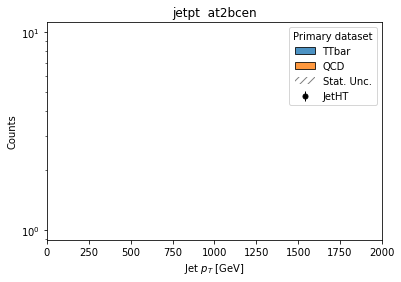

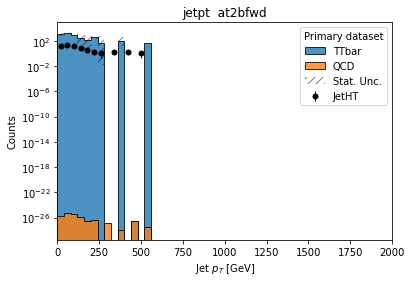

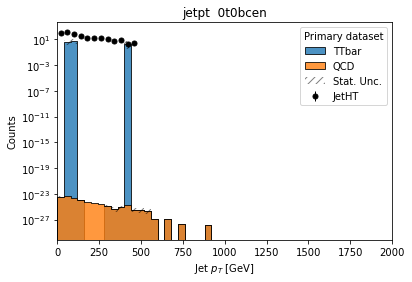

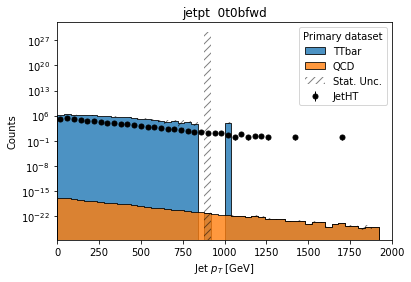

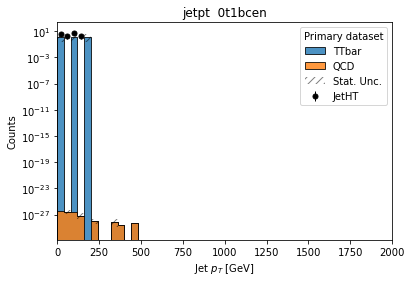

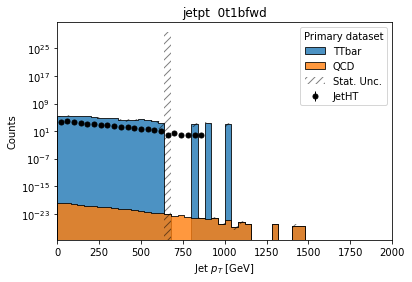

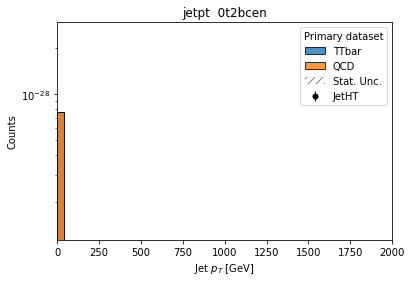

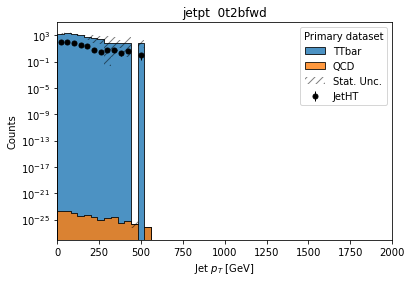

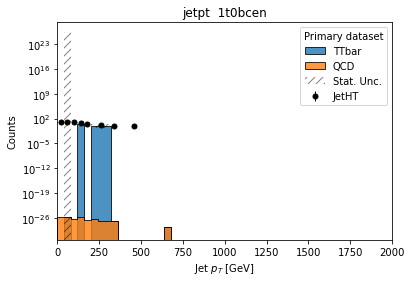

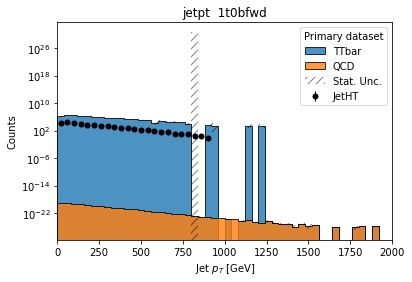

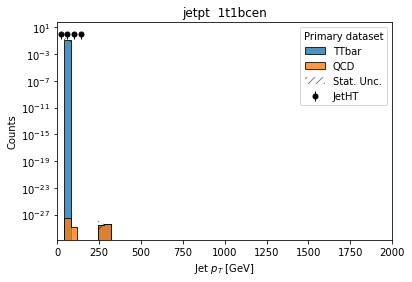

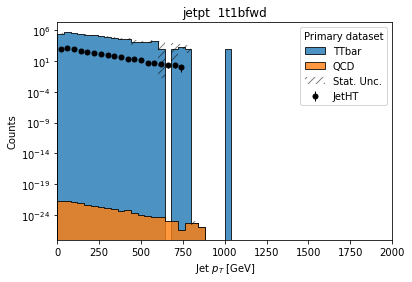

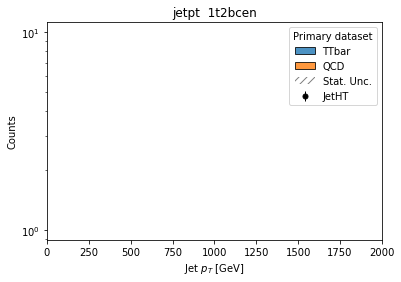

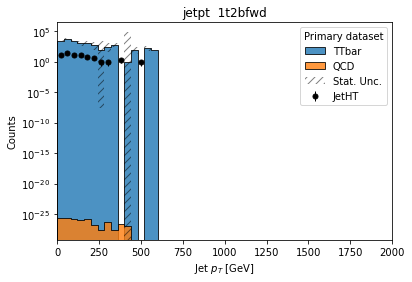

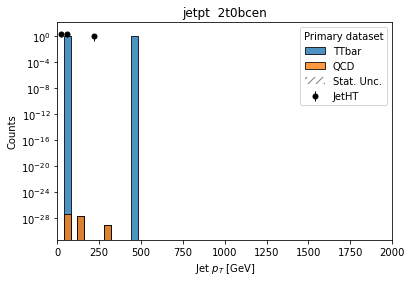

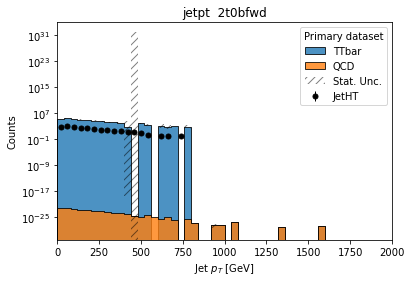

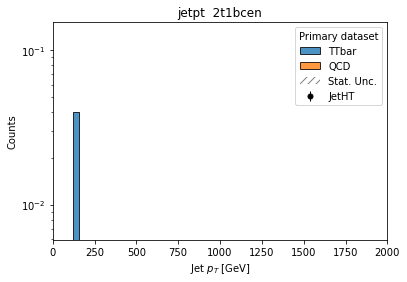

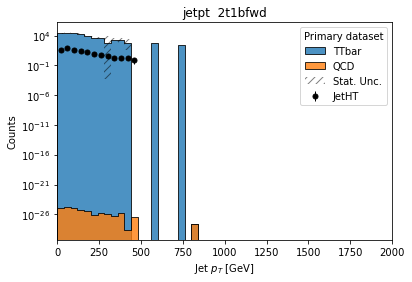

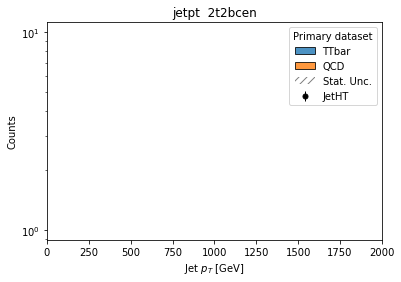

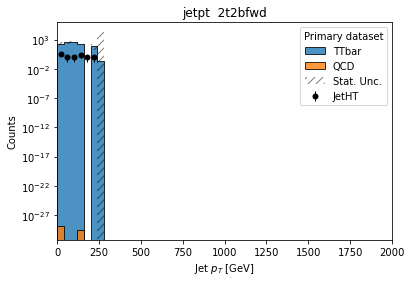

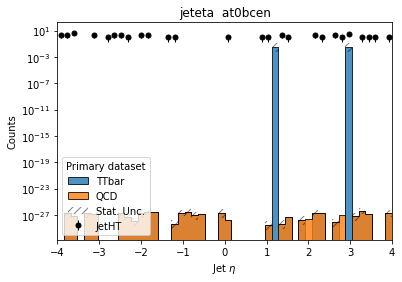

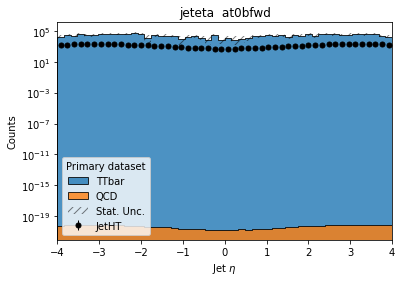

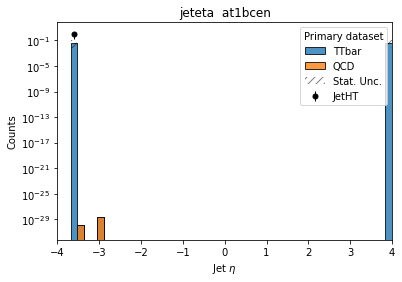

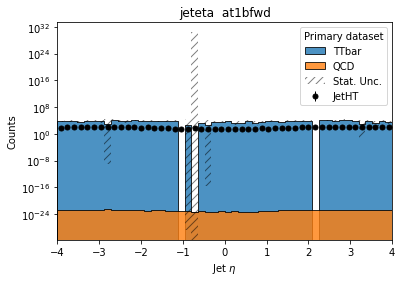

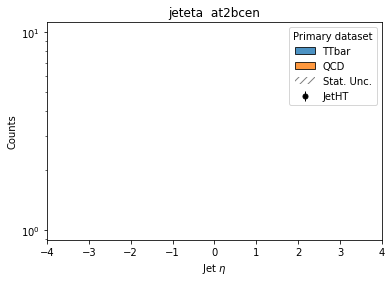

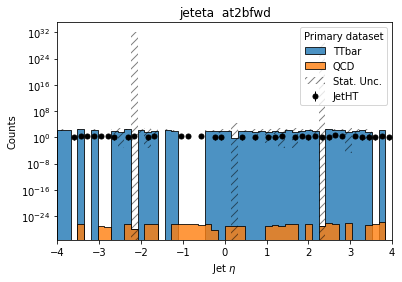

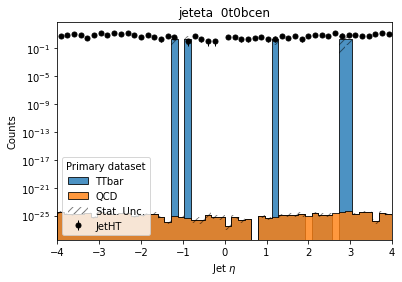

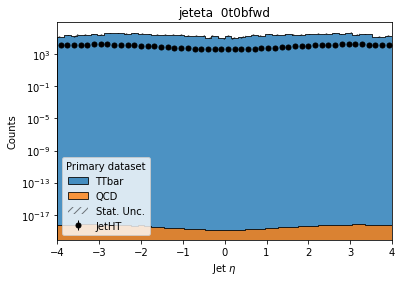

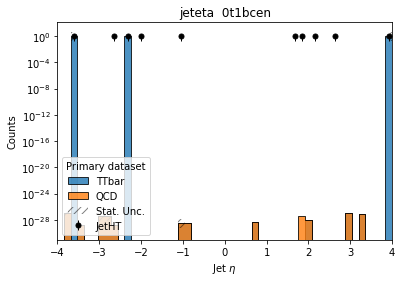

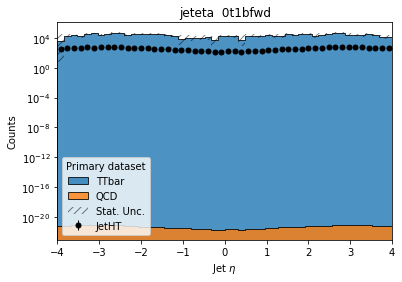

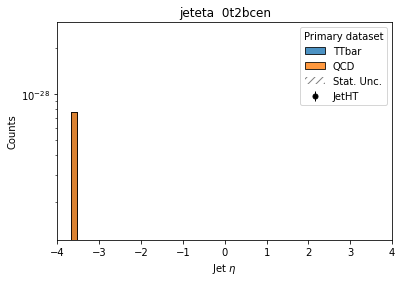

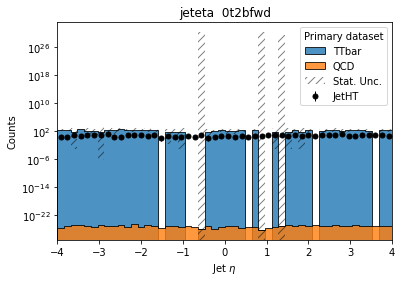

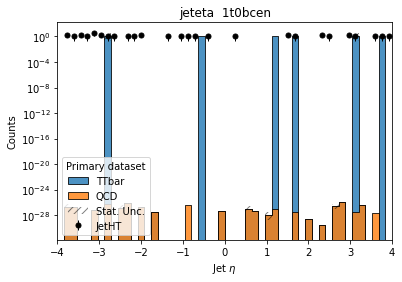

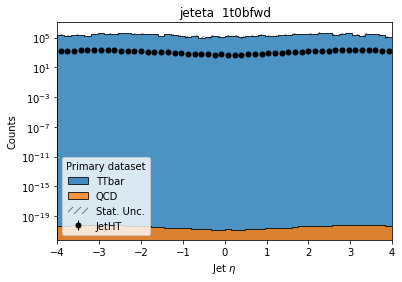

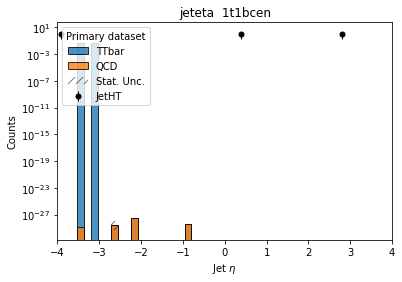

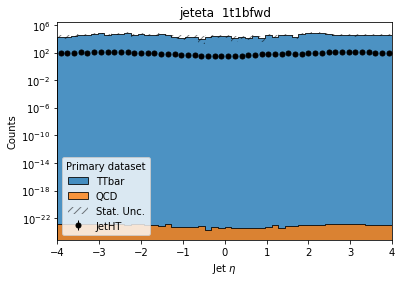

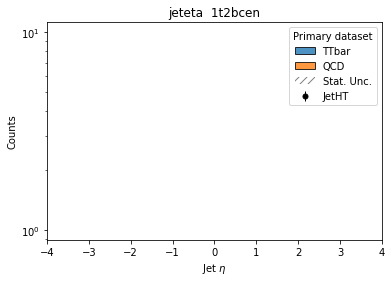

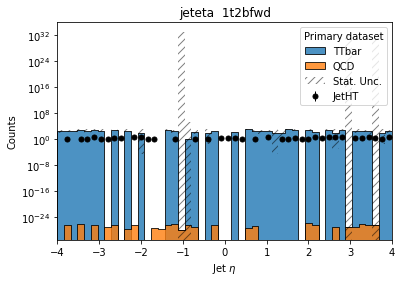

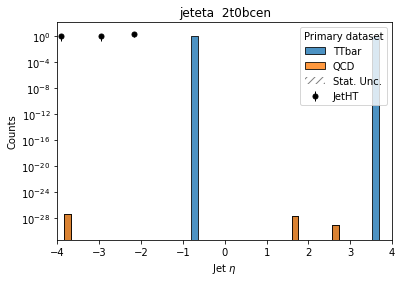

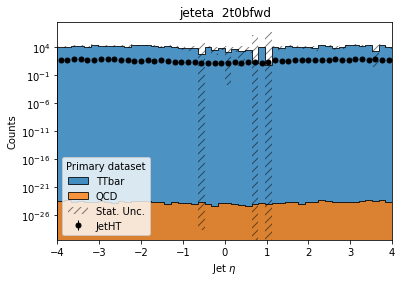

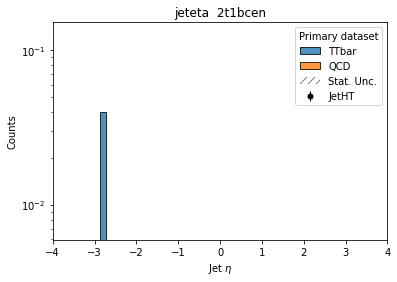

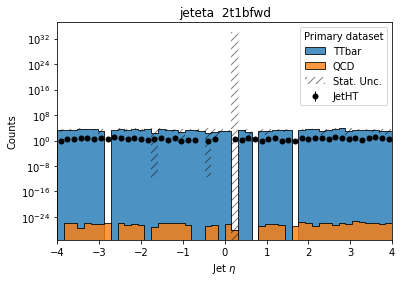

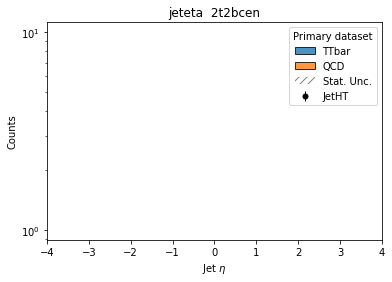

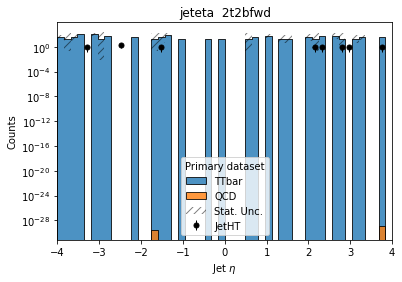

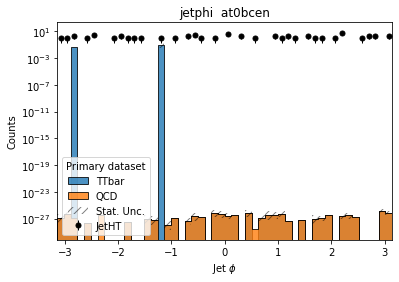

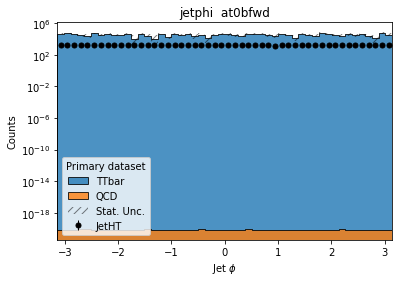

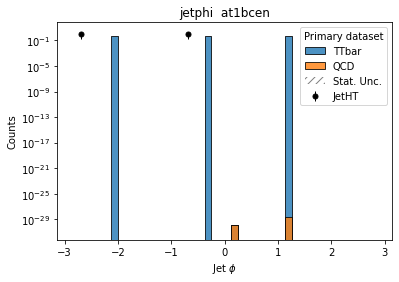

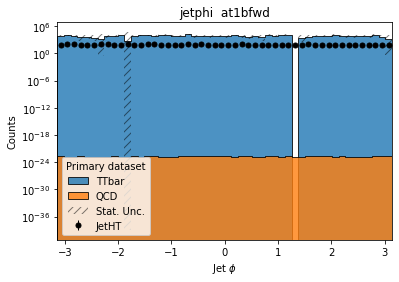

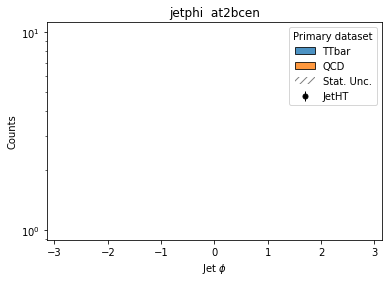

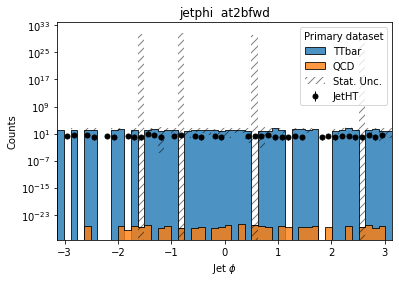

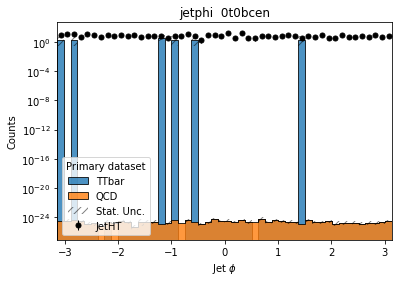

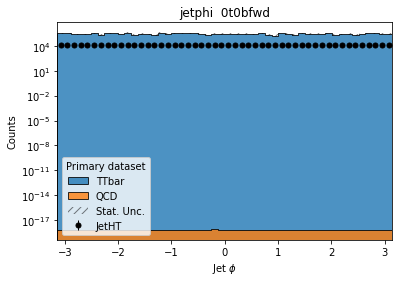

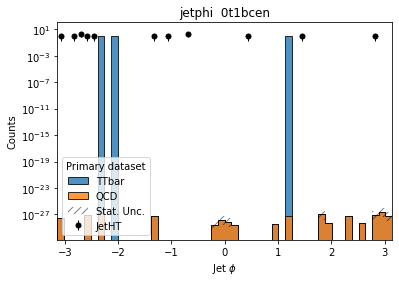

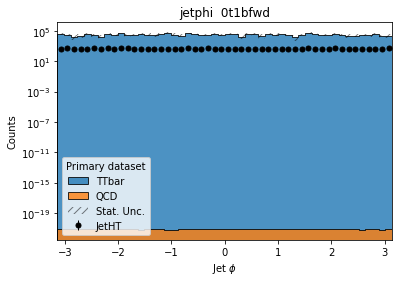

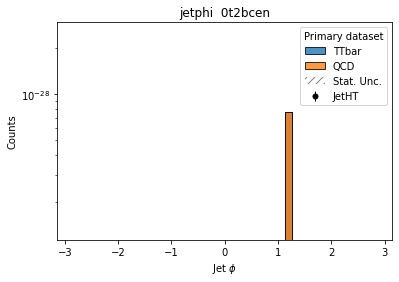

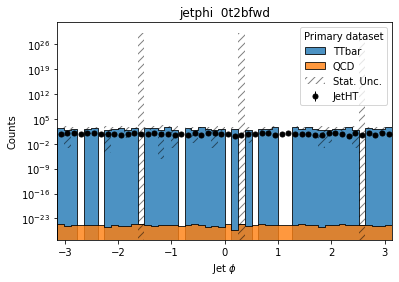

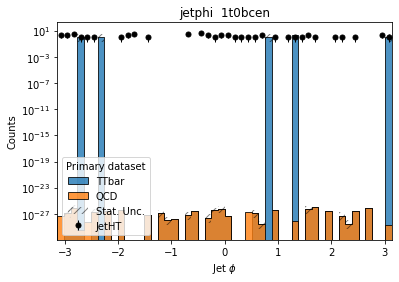

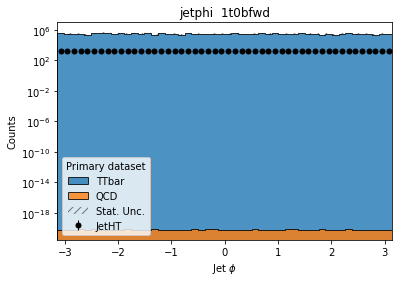

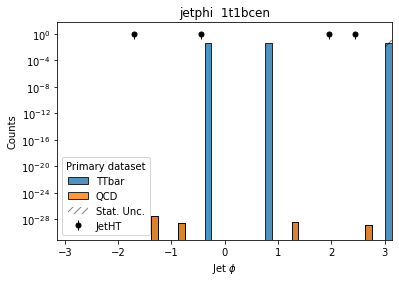

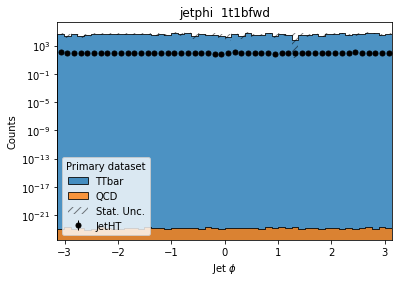

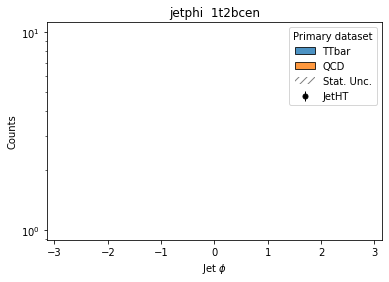

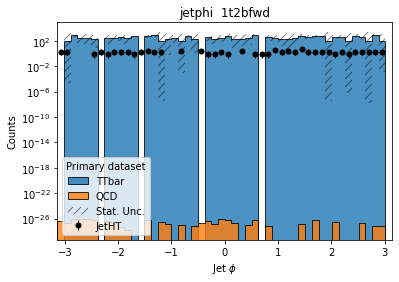

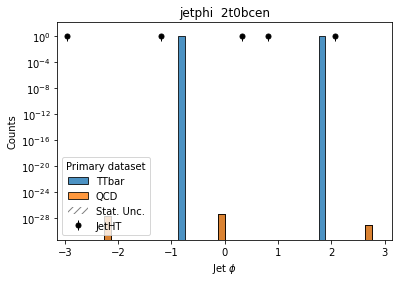

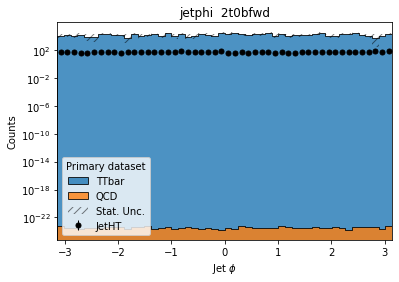

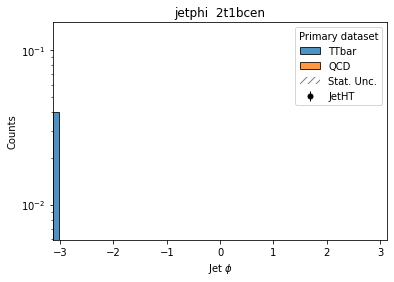

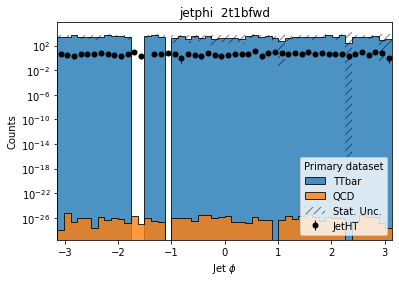

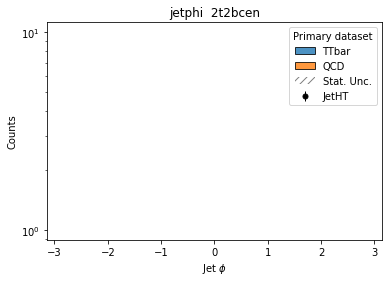

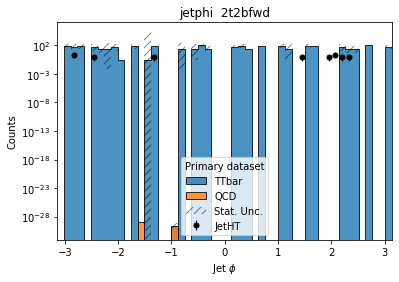

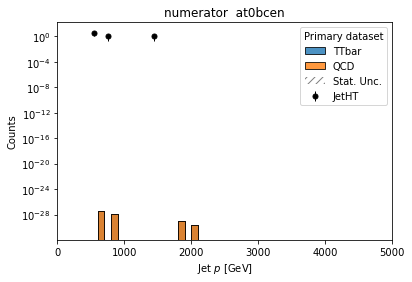

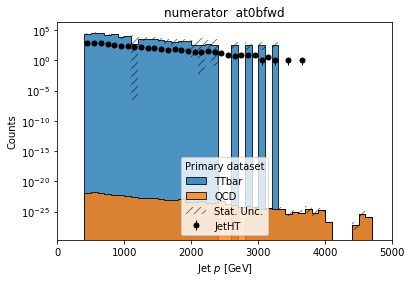

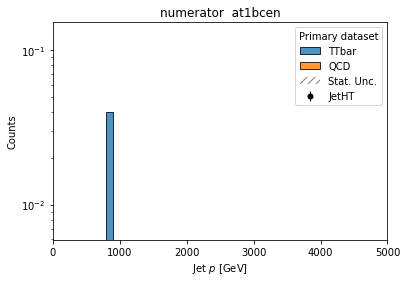

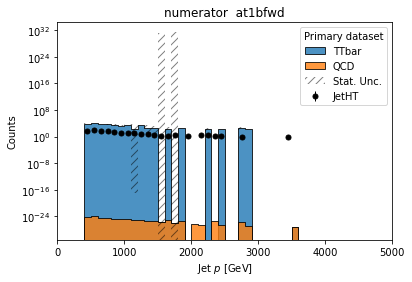

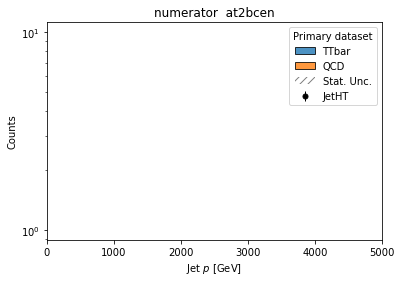

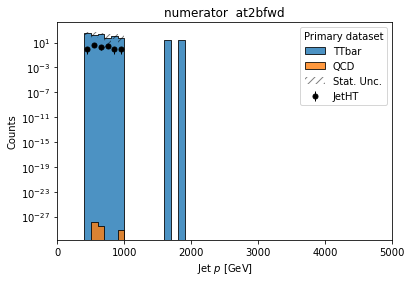

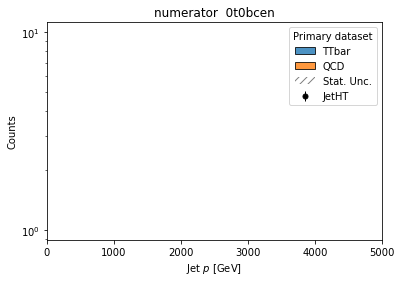

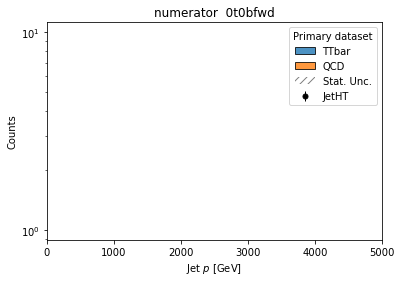

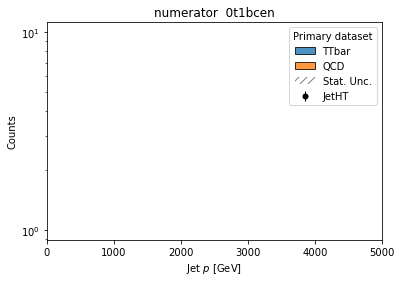

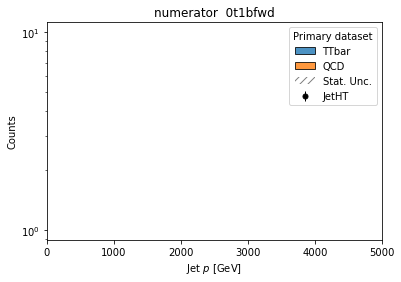

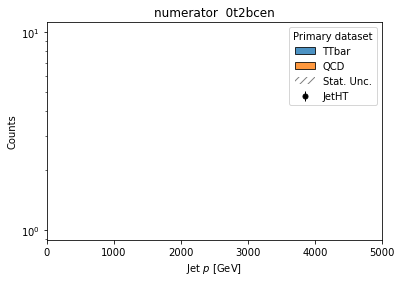

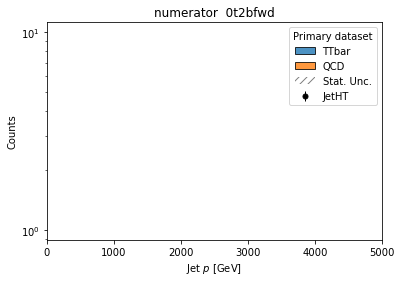

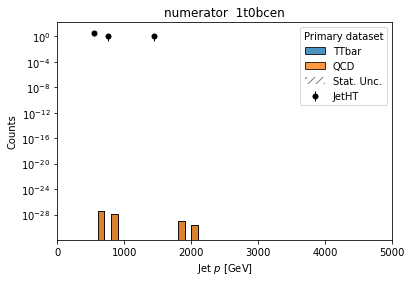

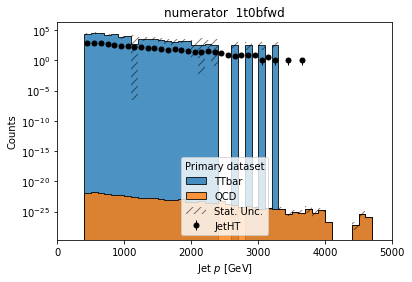

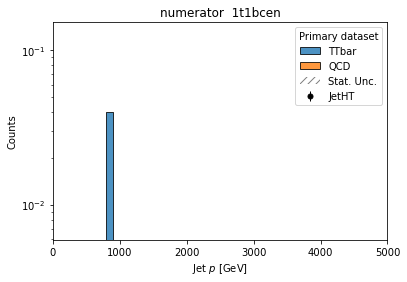

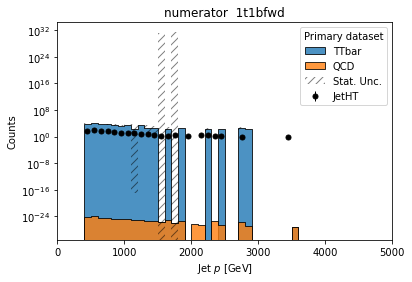

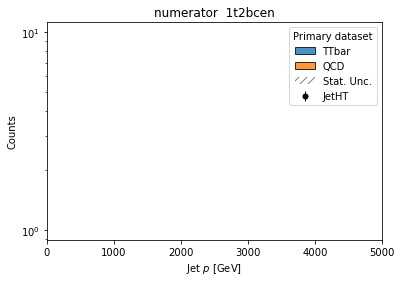

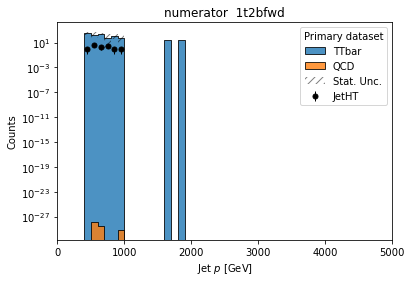

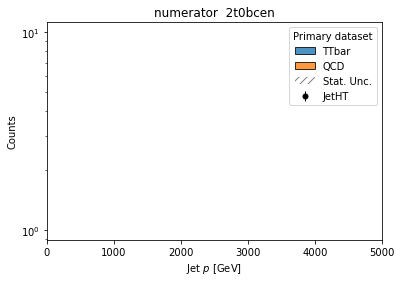

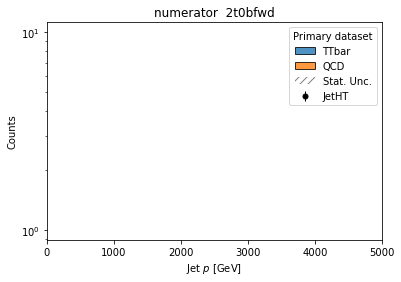

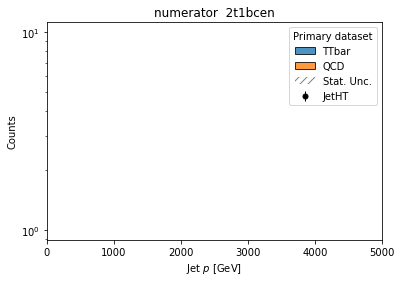

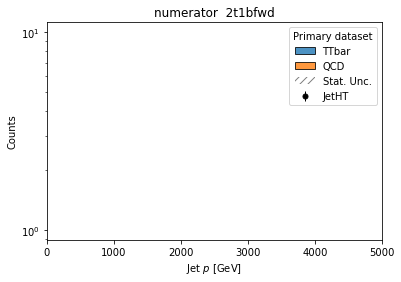

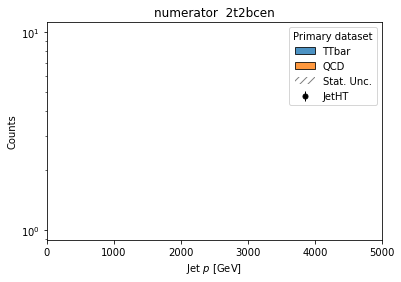

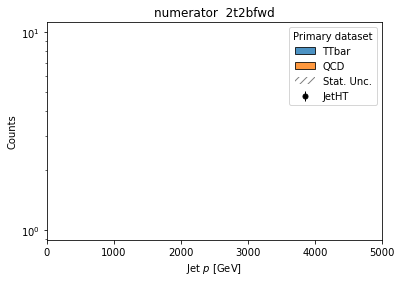

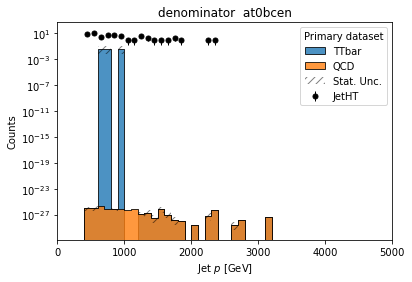

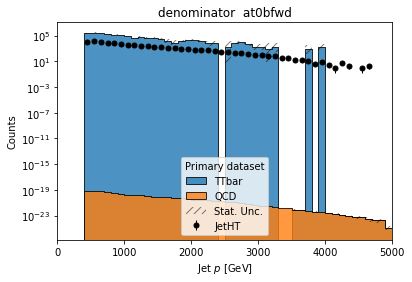

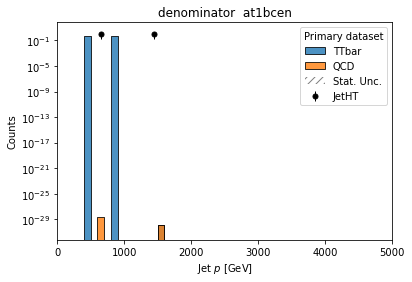

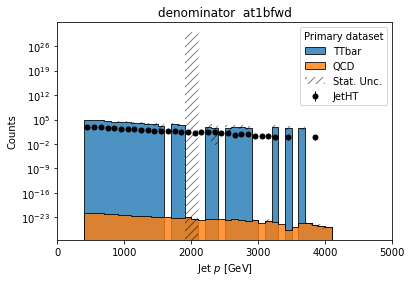

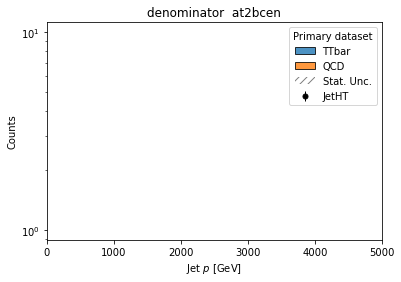

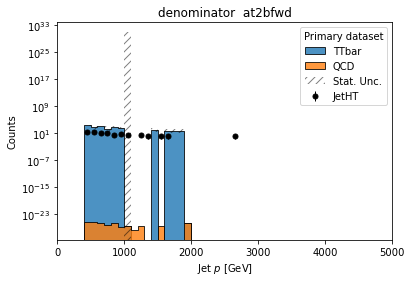

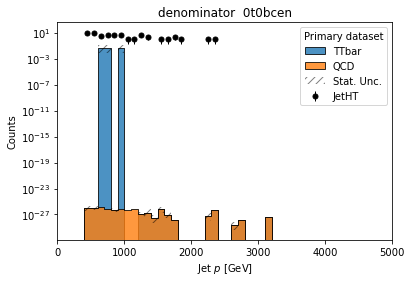

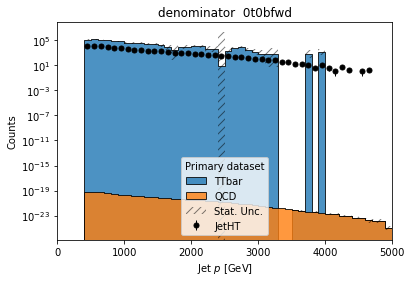

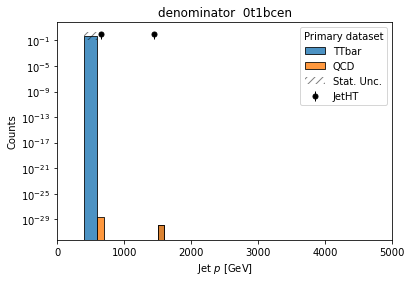

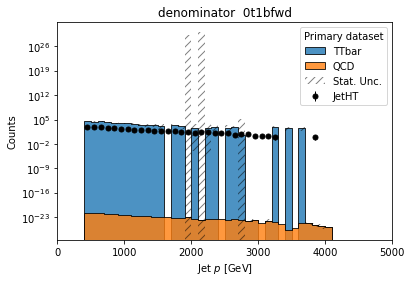

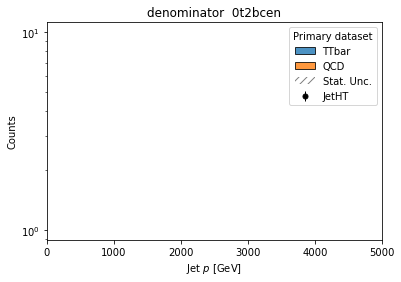

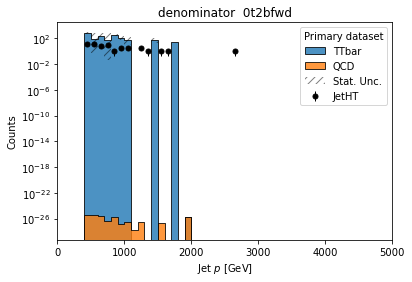

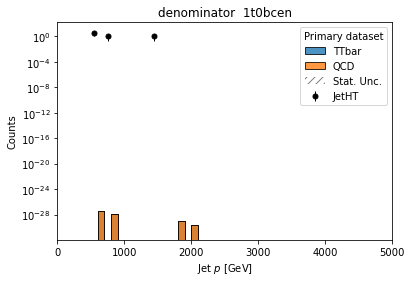

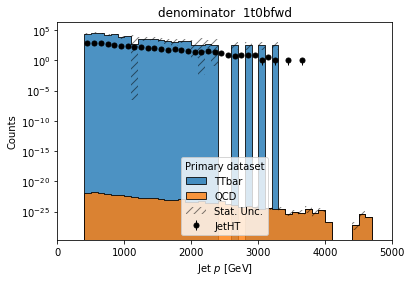

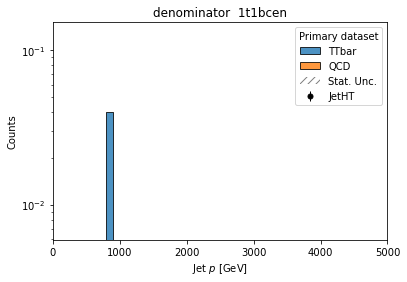

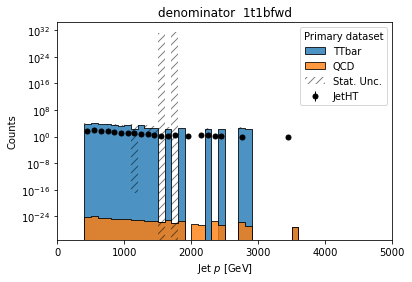

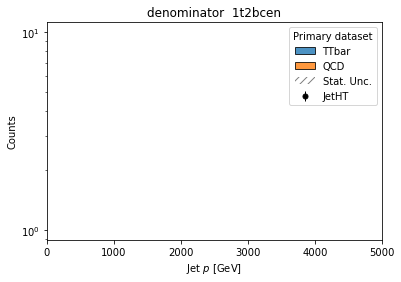

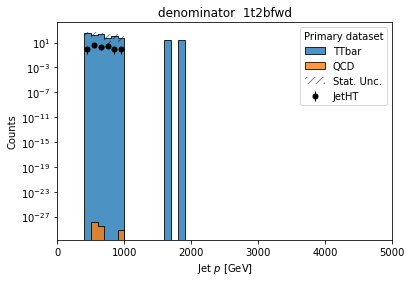

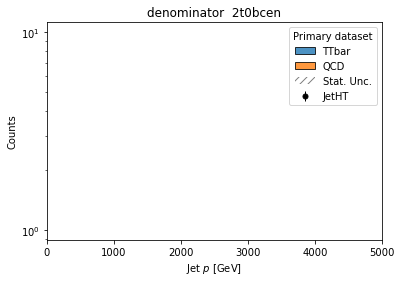

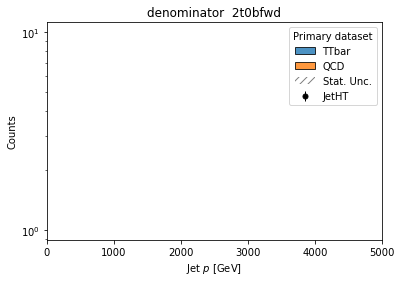

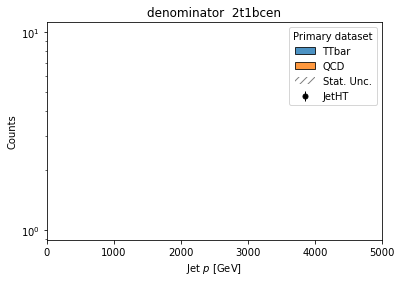

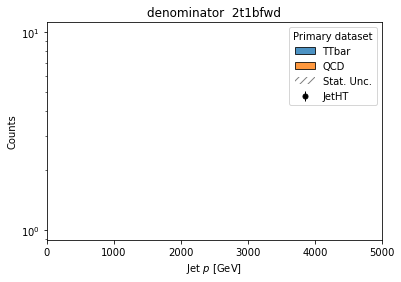

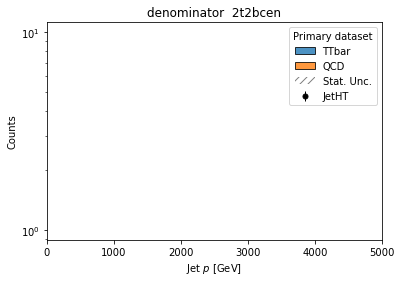

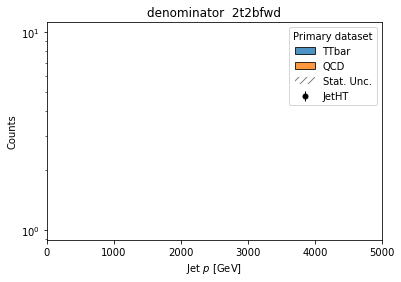

In [30]:
""" ---------------- CREATES ALL OTHER PLOTS AND RESCALES MONTE CARLO TO DATA ---------------- """
notdata = re.compile('(?!JetHT)') 
                    # why the .457 ?
ttbar_xs = 831.76 * 0.457 # pb for sqrt(s) = 13 TeV 
qcd_xs = 2022100000. # pb
Lum = 139230. #35900. # pb^-1 ; 139230 taken from  https://github.com/b2g-nano/TTbarAllHad/blob
                                #                 /master/test/controlplots/control_plots.ipynb

for ihist in list_of_hists:
    SaveDirectory = maindirectory + '/' + ihist + '/' # split histograms into subdirectories
    DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
    for icat in list_of_cats:
        plt.figure() # separates the plots for saving them 
        title = ihist + '  ' + icat
        filename = ihist + '_' + icat + '.' + 'png'
        #---- Define Histogram by categor y----# 
        histogram = output[ihist].integrate('anacat', icat)
        if ihist == 'numerator' or ihist == 'denominator':
            list_of_nevts = histogram.integrate('jetp').values()
        else:
            list_of_nevts = histogram.integrate(ihist).values() # events for each fileset, for each category
        #---- Re-scale Monte Carlo Histograms ----#
        TTbar_nevts = list_of_nevts[('TTbar',)] # pick out TTbar events for each category
        QCD_nevts = list_of_nevts[('QCD',)]
        
        if TTbar_nevts > 0:
            Lum_TTbar_MC = TTbar_nevts / ttbar_xs # 'Monte Carlo' Luminosity
        else:
            #print(icat + ' is empty for TTbar')
            Lum_TTbar_MC = 1
        if QCD_nevts > 0:
            Lum_QCD_MC = QCD_nevts / qcd_xs # only temporary for testing...
        else:
            #print(icat + ' is empty for QCD')
            Lum_QCD_MC = 1
        
        TTbar_sf = (Lum_TTbar_MC / Lum)
        QCD_sf = (Lum_QCD_MC / Lum)
        scales = {'TTbar': TTbar_sf,
                  'QCD': QCD_sf}
        histogram.scale(scales, 'dataset')
    
        #---- Plot Data ----#
        hist.plot1d(histogram['JetHT'], clear=False, error_opts=data_err_opts)
        #---- Plot MC ----#
        hist.plot1d(histogram[notdata], clear=False, overlay='dataset', stack=True,
                    fill_opts=stack_fill_opts, error_opts=stack_error_opts)
        
        plt.title(title)
        plt.yscale('log')
        plt.autoscale('y')
        plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        print(filename + ' saved')


In [31]:
""" ---------------- LOOK UP TABLE ---------------- """
import pandas as pd

for iset in fileset:
    print('\t\tfileset: ' + iset + '\n*****************************************************\n')
    for icat in list_of_cats:
        Numerator = output['numerator'].integrate('anacat',icat).integrate('dataset',iset)
        Denominator = output['denominator'].integrate('anacat',icat).integrate('dataset',iset)
        
        N_vals = Numerator.values()[()]
        D_vals = Denominator.values()[()]
    
        mistag_vals = np.where(D_vals > 0, N_vals / D_vals, 0)
        
        p_vals = [] # Momentum values
        for iden in Numerator.identifiers('jetp'):
            p_vals.append(iden)
        
        print('fileset:  ' + iset)
        print('category: ' + icat)
        print('________________________________________________\n')

        d = {'p': p_vals, 'M(p)': mistag_vals}
        
        df = pd.DataFrame(data=d)
        
        with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
            print(df)
        print('\n')

		fileset: TTbar
*****************************************************

fileset:  TTbar
category: at0bcen
________________________________________________

               p  M(p)
0       [0, 100)   0.0
1     [100, 200)   0.0
2     [200, 300)   0.0
3     [300, 400)   0.0
4     [400, 500)   0.0
5     [500, 600)   0.0
6     [600, 700)   0.0
7     [700, 800)   0.0
8     [800, 900)   0.0
9    [900, 1000)   0.0
10  [1000, 1100)   0.0
11  [1100, 1200)   0.0
12  [1200, 1300)   0.0
13  [1300, 1400)   0.0
14  [1400, 1500)   0.0
15  [1500, 1600)   0.0
16  [1600, 1700)   0.0
17  [1700, 1800)   0.0
18  [1800, 1900)   0.0
19  [1900, 2000)   0.0
20  [2000, 2100)   0.0
21  [2100, 2200)   0.0
22  [2200, 2300)   0.0
23  [2300, 2400)   0.0
24  [2400, 2500)   0.0
25  [2500, 2600)   0.0
26  [2600, 2700)   0.0
27  [2700, 2800)   0.0
28  [2800, 2900)   0.0
29  [2900, 3000)   0.0
30  [3000, 3100)   0.0
31  [3100, 3200)   0.0
32  [3200, 3300)   0.0
33  [3300, 3400)   0.0
34  [3400, 3500)   0.0
35  [3500, 3600)

fileset:  QCD
category: at1bfwd
________________________________________________

               p      M(p)
0       [0, 100)  0.000000
1     [100, 200)  0.000000
2     [200, 300)  0.000000
3     [300, 400)  0.000000
4     [400, 500)  0.074213
5     [500, 600)  0.084999
6     [600, 700)  0.043897
7     [700, 800)  0.059555
8     [800, 900)  0.048938
9    [900, 1000)  0.044442
10  [1000, 1100)  0.065056
11  [1100, 1200)  0.033568
12  [1200, 1300)  0.060815
13  [1300, 1400)  0.030738
14  [1400, 1500)  0.069818
15  [1500, 1600)  0.017221
16  [1600, 1700)  0.113734
17  [1700, 1800)  0.023166
18  [1800, 1900)  0.085942
19  [1900, 2000)  0.000000
20  [2000, 2100)  0.026165
21  [2100, 2200)  0.024933
22  [2200, 2300)  0.000000
23  [2300, 2400)  0.174471
24  [2400, 2500)  0.013696
25  [2500, 2600)  0.000000
26  [2600, 2700)  0.000000
27  [2700, 2800)  0.179496
28  [2800, 2900)  0.020680
29  [2900, 3000)  0.000000
30  [3000, 3100)  0.000000
31  [3100, 3200)  0.000000
32  [3200, 3300)  0.000000


fileset:  JetHT
category: 0t1bcen
________________________________________________

               p  M(p)
0       [0, 100)   0.0
1     [100, 200)   0.0
2     [200, 300)   0.0
3     [300, 400)   0.0
4     [400, 500)   0.0
5     [500, 600)   0.0
6     [600, 700)   0.0
7     [700, 800)   0.0
8     [800, 900)   0.0
9    [900, 1000)   0.0
10  [1000, 1100)   0.0
11  [1100, 1200)   0.0
12  [1200, 1300)   0.0
13  [1300, 1400)   0.0
14  [1400, 1500)   0.0
15  [1500, 1600)   0.0
16  [1600, 1700)   0.0
17  [1700, 1800)   0.0
18  [1800, 1900)   0.0
19  [1900, 2000)   0.0
20  [2000, 2100)   0.0
21  [2100, 2200)   0.0
22  [2200, 2300)   0.0
23  [2300, 2400)   0.0
24  [2400, 2500)   0.0
25  [2500, 2600)   0.0
26  [2600, 2700)   0.0
27  [2700, 2800)   0.0
28  [2800, 2900)   0.0
29  [2900, 3000)   0.0
30  [3000, 3100)   0.0
31  [3100, 3200)   0.0
32  [3200, 3300)   0.0
33  [3300, 3400)   0.0
34  [3400, 3500)   0.0
35  [3500, 3600)   0.0
36  [3600, 3700)   0.0
37  [3700, 3800)   0.0
38  [3800, 3900)   

In [ ]:
print("Events/s:", output['cutflow']['all events']/elapsed)

In [ ]:
for i,j in output['cutflow'].items():
    print( '%20s : %12d' % (i,j) )

In [ ]:

#mapping = {
#    'QCD': ['QCD'],
#}
#output['ttbarmass'].group("dataset", hist.Cat("dataset", "dataset"), mapping)
#hist_noDS = output['ttbarmass_pretag'].integrate('dataset')


In [ ]:
""" ---------------- TEST TO RESCALE MONTE CARLO PLOTS ---------------- """
"""
list_of_hists = ('ttbarmass', 'jetpt', 'jeteta', 'jetphi')
xs = 831.76 # pb for sqrt(s) = 13 TeV
Lum = 35900. # pb^-1 from experiment
for ihist in list_of_hists:
    for icat in list_of_cats: 
        #----Define Histogram by category----# 
        histogram = output[ihist].integrate('anacat', icat)
        list_of_nevts = histogram.integrate(ihist).values() # events for each fileset, for each category
        
        TTbar_nevts = list_of_nevts[('TTbar',)] # pick out TTbar events for each category
        QCD_nevts = list_of_nevts[('QCD',)]
        
        if TTbar_nevts > 0:
            Lum_TTbar_MC = TTbar_nevts / xs # 'Monte Carlo' Luminosity
        else:
            #print(icat + ' is empty for TTbar')
            Lum_TTbar_MC = 1
        if QCD_nevts > 0:
            Lum_QCD_MC = QCD_nevts / xs
        else:
            #print(icat + ' is empty for QCD')
            Lum_QCD_MC = 1
        
        TTbar_sf = Lum / Lum_TTbar_MC
        QCD_sf = Lum / Lum_QCD_MC
        scales = {'TTbar': TTbar_sf,
                  'QCD': QCD_sf}
        histogram.scale(scales, 'dataset')
        plt.figure()
        plt.ylim(bottom=10**(-8))
        plt.yscale('log')
        hist.plot1d(histogram, fill_opts=stack_fill_opts, error_opts=stack_error_opts)
"""

In [ ]:
""" ----------- DECLARE (AND DISPLAY) ALL PLOTS ----------- """
""" Only remove stack=True option when using only one fileset """
""" This is not what the final figures will look like """
"""
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

axes_ttbarmass = hist.plotgrid(output['ttbarmass'], row="anacat", overlay="dataset", stack=True,
                               fill_opts=stack_fill_opts, error_opts=stack_error_opts)
plt.ylim(bottom=10**(-8))
plt.yscale('log')
plt.autoscale(enable=True, axis='y')

axes_numerator = hist.plotgrid(output['numerator'], row="anacat", overlay="dataset", stack=True,
                               fill_opts=stack_fill_opts, error_opts=stack_error_opts)
plt.ylim(bottom=10**(-8))
plt.yscale('log')
plt.autoscale(enable=True, axis='y')

axes_denominator = hist.plotgrid(output['denominator'], row="anacat", overlay="dataset", stack=True,
                               fill_opts=stack_fill_opts, error_opts=stack_error_opts)
plt.ylim(bottom=10**(-8))
plt.yscale('log')
plt.autoscale(enable=True, axis='y')

axes_jetpt = hist.plotgrid(output['jetpt'], row="anacat", overlay="dataset", stack=True,
                               fill_opts=stack_fill_opts, error_opts=stack_error_opts)
plt.ylim(bottom=10**(-8))
plt.yscale('log')
plt.autoscale(enable=True, axis='y')

axes_jeteta = hist.plotgrid(output['jeteta'], row="anacat", overlay="dataset", stack=True,
                               fill_opts=stack_fill_opts, error_opts=stack_error_opts)
plt.ylim(bottom=10**(-8))
plt.yscale('log')
plt.autoscale(enable=True, axis='y')

axes_jetphi = hist.plotgrid(output['jeteta'], row="anacat", overlay="dataset", stack=True,
                               fill_opts=stack_fill_opts, error_opts=stack_error_opts)
plt.ylim(bottom=10**(-8))
plt.yscale('log')
plt.autoscale(enable=True, axis='y')
"""

In [ ]:
"""
# (hist, string, string, string, string)

def SavePlot(name_of_axis, name_of_cat, name_of_plot, plot_type, name_of_directory): 
    title = name_of_cat
    filename = '/' + name_of_plot + '_' + title + '.' + plot_type
    plt.title(title) 
    plt.savefig(name_of_directory + filename, bbox_inches="tight")
    print(filename + " successfully created")
"""

In [ ]:
"""
SaveDirectory = maindirectory + '/MistagPlots'
DoesDirectoryExist(SaveDirectory) # no need to create the directory several times

for icat in list_of_cats:
    title = 'QCD mistag ' + icat
    filename = 'mistag_QCD' + '_' + icat + '.' + 'ps'
    Numerator = output['numerator'].integrate('anacat', icat).integrate('dataset', 'QCD')
    Denominator = output['denominator'].integrate('anacat', icat).integrate('dataset', 'QCD')
    mistag = hist.plotratio(num = Numerator, denom = Denominator,
                            error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                            unc = 'num')
    plt.title(title)
    plt.autoscale('y')
    print(filename + ' saved')
"""

In [ ]:
# --------------- OLD METHOD OF SAVING --------------- #

"""
directory = '/uscms_data/d1/acwillia/singularity/TTbarAllHadUprootFork/TTbarAllHadUproot' # change accordingly...

SaveDirectory = directory + '/MistagPlots'
DoesDirectoryExist(SaveDirectory) # no need to create the directory several times

for iax in axes_numerator.flatten():
    category = iax.get_title()
    Numerator = output['numerator'].integrate('anacat', category).integrate('dataset', 'TTbar')
    Denominator = output['denominator'].integrate('anacat', category).integrate('dataset', 'TTbar')
    mistag = hist.plotratio(num = Numerator, denom = Denominator,
                            error_opts={'color': 'b', 'marker': 'x', 'ms':5},
                            unc = 'clopper-pearson')
    SavePlot(mistag, category, 'mistag_TTbar', 'pdf', SaveDirectory)
    


for iax in axes_numerator.flatten():
    category = iax.get_title()
    Numerator = output['numerator'].integrate('anacat', category).integrate('dataset', 'QCD')
    Denominator = output['denominator'].integrate('anacat', category).integrate('dataset', 'QCD')
    mistag = hist.plotratio(num = Numerator, denom = Denominator,
                            error_opts={'color': 'r', 'marker': '+', 'ms':5},
                            unc = 'clopper-pearson')
    SavePlot(mistag, category, 'mistag_QCD', 'pdf', SaveDirectory)
    


for iax in axes_numerator.flatten():
    category = iax.get_title()
    Numerator = output['numerator'].integrate('anacat', category).integrate('dataset', 'JetHT')
    Denominator = output['denominator'].integrate('anacat', category).integrate('dataset', 'JetHT')
    mistag = hist.plotratio(num = Numerator, denom = Denominator,
                            error_opts={'color': 'g', 'marker': '*', 'ms':5},
                            unc = 'clopper-pearson')
    SavePlot(mistag, category, 'mistag_JetHT', 'pdf', SaveDirectory)
"""    
"""___________________________________________________________________________________________________________"""
"""
SaveDirectory = directory + '/TTbarmassPlots'
DoesDirectoryExist(SaveDirectory) 
for iax in axes_ttbarmass.flatten():
    category = iax.get_title()
    bx = hist.plotgrid(output['ttbarmass'].integrate('anacat',category), overlay="dataset", stack=True, 
                       fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    plt.ylim(top = 10**6, bottom=10**(-8))
    plt.yscale('log')
    SavePlot(bx, category, 'ttbarmass', 'pdf', SaveDirectory)


SaveDirectory = directory + '/NumeratorPlots'
DoesDirectoryExist(SaveDirectory) 
for iax in axes_numerator.flatten():
    category = iax.get_title()
    bx = hist.plotgrid(output['numerator'].integrate('anacat',category), overlay="dataset", stack=True,
                       fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    plt.ylim(top = 10**6, bottom=10**(-8))
    plt.yscale('log')
    SavePlot(bx, category, 'numerator', 'pdf', SaveDirectory)

    

SaveDirectory = directory + '/DenominatorPlots'
DoesDirectoryExist(SaveDirectory)
for iax in axes_denominator.flatten():
    category = iax.get_title()
    bx = hist.plotgrid(output['denominator'].integrate('anacat',category), overlay="dataset", stack=True,
                       fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    plt.ylim(top = 10**6, bottom=10**(-8))
    plt.yscale('log')
    SavePlot(bx, category, 'denominator', 'pdf', SaveDirectory)



SaveDirectory = directory + '/JetptPlots'
DoesDirectoryExist(SaveDirectory)
for iax in axes_denominator.flatten():
    category = iax.get_title()
    bx = hist.plotgrid(output['jetpt'].integrate('anacat',category), overlay="dataset", stack=True,
                       fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    plt.ylim(top = 10**6, bottom=10**(-8))
    plt.yscale('log')
    SavePlot(bx, category, 'jetpt', 'pdf', SaveDirectory)


SaveDirectory = directory + '/JetetaPlots'
DoesDirectoryExist(SaveDirectory)
for iax in axes_denominator.flatten():
    category = iax.get_title()
    bx = hist.plotgrid(output['jeteta'].integrate('anacat',category), overlay="dataset", stack=True,
                       fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    plt.ylim(top = 10**6, bottom=10**(-8))
    plt.yscale('log')
    SavePlot(bx, category, 'jeteta', 'pdf', SaveDirectory)


SaveDirectory = directory + '/JetphiPlots'
DoesDirectoryExist(SaveDirectory)
for iax in axes_denominator.flatten():
    category = iax.get_title()
    bx = hist.plotgrid(output['jetphi'].integrate('anacat',category), overlay="dataset", stack=True,
                       fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    plt.ylim(top = 10**6, bottom=10**(-8))
    plt.yscale('log')
    SavePlot(bx, category, 'jetphi', 'pdf', SaveDirectory)
"""